In [ ]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from keras.models import Sequential
from keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Lambda
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from scipy.stats import mode
from keras.layers import concatenate, Conv1D, Softmax, multiply, Permute, Flatten
from keras import Input, Model
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Dropout, TimeDistributed, BatchNormalization
from keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Concatenate, Dense, AveragePooling1D
from keras.models import Model
from re import U

In [ ]:
from scipy.io import loadmat
from keras.utils import to_categorical
from keras.layers import *
# from keras.layers.core import *
from keras.models import *
from keras.optimizers import *
from keras.backend import sum
import numpy as np
from scipy.stats import mode
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense,Bidirectional,LSTM

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
np.random.seed(2)
import tensorflow as tf
import scipy.io
import h5py
import keras
!pip install hdf5storage
import hdf5storage
!pip install xlwt
import xlwt as xw

from keras.layers import *
# from keras.layers.core import *
from keras.models import *
from keras.regularizers import *
from keras.optimizers import *
from keras.losses import *
from keras import metrics
from keras import backend as K
from keras.backend import sum, mean, max
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from matplotlib import pyplot

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def crop(dimension, start, end):
    # Thanks to marc-moreaux on Github page:https://github.com/keras-team/keras/issues/890 who created this beautiful and sufficient function: )
    # Crops (or slices) a Tensor on a given dimension from start to end
    # example : to crop tensor x[:, :, 5:10]
    # call slice(2, 5, 10) as you want to crop on the second dimension
    def func(x):
        if dimension == 0:
            return x[start: end]
        if dimension == 1:
            return x[:, start: end]
        if dimension == 2:
            return x[:, :, start: end]
        if dimension == 3:
            return x[:, :, :, start: end]
        if dimension == 4:
            return x[:, :, :, :, start: end]
    return Lambda(func)

In [ ]:
def build_banet_model():
    timestep = 180   # length of an input frame
    dimension = 66   # dimension of an input frame, 66 = 22 joints by 3 xyz coordinates, the 4 coordinates of the foot are removed.
    BodyNum = 22     # number of body segments (different sensors) to consider

    #Model 1: Temporal Information encoding model for BANet (keras Model API)
    singleinput = Input(shape=(180, 3,))
    lstm_units = 8
    LSTM1 = LSTM(lstm_units, return_sequences=True)(singleinput) # Refer to https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM to decide if 'CuDNN' is needed.
    Dropout1 = Dropout(0.5)(LSTM1)
    LSTM2 = LSTM(lstm_units, return_sequences=True)(Dropout1)
    Dropout2 = Dropout(0.5)(LSTM2)
    LSTM3 = LSTM(lstm_units, return_sequences=True)(Dropout2)
    Dropout3 = Dropout(0.5)(LSTM3)
    TemporalProcessmodel = Model(inputs=[singleinput], outputs=[Dropout3])
    # TemporalProcessmodel.summary()

    # Model 2: Main Structure, starting with independent temporal information encoding and attention learning
    inputs = Input(shape=(180, 66,))      # The input data is 180 timesteps by 66 features (22 joints by 3 xyz coordinates)
    # The information each body segment provides is the coordinates of each joint

    x1 = crop(2, 0, 1)(inputs)
    y1 = crop(2, 22, 23)(inputs)
    z1 = crop(2, 44,45)(inputs)
    B1 = concatenate([x1, y1, z1], axis=-1)

    Anglefullout1 = TemporalProcessmodel(B1)

    TemporalAttention1 = Conv1D(1, 1, strides=1)(Anglefullout1) # Temporal Attention Module for each body segment will starts with 1 X 1 Convolution
    TemporalAttention1 = Softmax(axis=-2, name='TemporalAtten1')(TemporalAttention1) # You need Keras >= 2.1.3 to call Softmax as a layer
    AngleAttout1 = multiply([Anglefullout1, TemporalAttention1])
    AngleAttout1 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout1)
    Blast1 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout1)

    x2 = crop(2, 1, 2)(inputs)
    y2 = crop(2, 23, 24)(inputs)
    z2 = crop(2, 45, 46)(inputs)
    B2 = concatenate([x2, y2, z2], axis=-1)
    Anglefullout2 = TemporalProcessmodel(B2)

    TemporalAttention2 = Conv1D(1, 1, strides=1)(Anglefullout2)
    TemporalAttention2 = Softmax(axis=-2, name='TemporalAtten2')(TemporalAttention2)
    AngleAttout2 = multiply([Anglefullout2, TemporalAttention2])
    AngleAttout2 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout2)
    Blast2 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout2)

    x3 = crop(2, 2, 3)(inputs)
    y3 = crop(2, 24, 25)(inputs)
    z3 = crop(2, 46, 47)(inputs)
    B3 = concatenate([x3, y3, z3], axis=-1)
    Anglefullout3 = TemporalProcessmodel(B3)
    TemporalAttention3 = Conv1D(1, 1, strides=1)(Anglefullout3)
    TemporalAttention3 = Softmax(axis=-2, name='TemporalAtten3')(TemporalAttention3)
    AngleAttout3 = multiply([Anglefullout3, TemporalAttention3])
    AngleAttout3 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout3)
    Blast3 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout3)

    x4 = crop(2, 3, 4)(inputs)
    y4 = crop(2, 25, 26)(inputs)
    z4 = crop(2, 47, 48)(inputs)
    B4 = concatenate([x4, y4, z4], axis=-1)
    Anglefullout4 = TemporalProcessmodel(B4)
    TemporalAttention4 = Conv1D(1, 1, strides=1)(Anglefullout4)
    TemporalAttention4 = Softmax(axis=-2, name='TemporalAtten4')(TemporalAttention4)
    AngleAttout4 = multiply([Anglefullout4, TemporalAttention4])
    AngleAttout4 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout4)
    Blast4 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout4)

    x5 = crop(2, 4, 5)(inputs)
    y5 = crop(2, 26, 27)(inputs)
    z5 = crop(2, 48, 49)(inputs)
    B5 = concatenate([x5, y5, z5], axis=-1)
    Anglefullout5 = TemporalProcessmodel(B5)
    TemporalAttention5 = Conv1D(1, 1, strides=1)(Anglefullout5)
    TemporalAttention5 = Softmax(axis=-2, name='TemporalAtten5')(TemporalAttention5)
    AngleAttout5 = multiply([Anglefullout5, TemporalAttention5])
    AngleAttout5 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout5)
    Blast5 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout5)

    x6 = crop(2, 5, 6)(inputs)
    y6 = crop(2, 27, 28)(inputs)
    z6 = crop(2, 49, 50)(inputs)
    B6 = concatenate([x6, y6, z6], axis=-1)
    Anglefullout6 = TemporalProcessmodel(B6)
    TemporalAttention6 = Conv1D(1, 1, strides=1)(Anglefullout6)
    TemporalAttention6 = Softmax(axis=-2, name='TemporalAtten6')(TemporalAttention6)
    AngleAttout6 = multiply([Anglefullout6, TemporalAttention6])
    AngleAttout6 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout6)
    Blast6 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout6)

    x7 = crop(2, 6, 7)(inputs)
    y7 = crop(2, 28, 29)(inputs)
    z7 = crop(2, 50, 51)(inputs)
    B7 = concatenate([x7, y7, z7], axis=-1)
    Anglefullout7 = TemporalProcessmodel(B7)
    TemporalAttention7 = Conv1D(1, 1, strides=1)(Anglefullout7)
    TemporalAttention7 = Softmax(axis=-2, name='TemporalAtten7')(TemporalAttention7)
    AngleAttout7 = multiply([Anglefullout7, TemporalAttention7])
    AngleAttout7 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout7)
    Blast7 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout7)

    x8 = crop(2, 7, 8)(inputs)
    y8 = crop(2, 29, 30)(inputs)
    z8 = crop(2, 51, 52)(inputs)
    B8 = concatenate([x8, y8, z8], axis=-1)
    Anglefullout8 = TemporalProcessmodel(B8)
    TemporalAttention8 = Conv1D(1, 1, strides=1)(Anglefullout8)
    TemporalAttention8 = Softmax(axis=-2, name='TemporalAtten8')(TemporalAttention8)
    AngleAttout8 = multiply([Anglefullout8, TemporalAttention8])
    AngleAttout8 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout8)
    Blast8 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout8)

    x9 = crop(2, 8, 9)(inputs)
    y9 = crop(2, 30, 31)(inputs)
    z9 = crop(2, 52, 53)(inputs)
    B9 = concatenate([x9, y9, z9], axis=-1)
    Anglefullout9 = TemporalProcessmodel(B9)
    TemporalAttention9 = Conv1D(1, 1, strides=1)(Anglefullout9)
    TemporalAttention9 = Softmax(axis=-2, name='TemporalAtten9')(TemporalAttention9)
    AngleAttout9 = multiply([Anglefullout9, TemporalAttention9])
    AngleAttout9 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout9)
    Blast9 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout9)

    x10 = crop(2, 9, 10)(inputs)
    y10 = crop(2, 31, 32)(inputs)
    z10 = crop(2, 53, 54)(inputs)
    B10 = concatenate([x10, y10, z10], axis=-1)
    Anglefullout10 = TemporalProcessmodel(B10)
    TemporalAttention10 = Conv1D(1, 1, strides=1)(Anglefullout10)
    TemporalAttention10 = Softmax(axis=-2, name='TemporalAtten10')(TemporalAttention10)
    AngleAttout10 = multiply([Anglefullout10, TemporalAttention10])
    AngleAttout10 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout10)
    Blast10 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout10)

    x11 = crop(2, 10, 11)(inputs)
    y11 = crop(2, 32, 33)(inputs)
    z11 = crop(2, 54, 55)(inputs)
    B11 = concatenate([x11, y11, z11], axis=-1)
    Anglefullout11 = TemporalProcessmodel(B11)
    TemporalAttention11 = Conv1D(1, 1, strides=1)(Anglefullout11)
    TemporalAttention11 = Softmax(axis=-2, name='TemporalAtten11')(TemporalAttention11)
    AngleAttout11 = multiply([Anglefullout11, TemporalAttention11])
    AngleAttout11 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout11)
    Blast11 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout11)

    x12 = crop(2, 11, 12)(inputs)
    y12 = crop(2, 33, 34)(inputs)
    z12 = crop(2, 55, 56)(inputs)
    B12 = concatenate([x12, y12, z12], axis=-1)
    Anglefullout12 = TemporalProcessmodel(B12)
    TemporalAttention12 = Conv1D(1, 1, strides=1)(Anglefullout12)
    TemporalAttention12 = Softmax(axis=-2, name='TemporalAtten12')(TemporalAttention12)
    AngleAttout12 = multiply([Anglefullout12, TemporalAttention12])
    AngleAttout12 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout12)
    Blast12 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout12)

    x13 = crop(2, 12, 13)(inputs)
    y13 = crop(2, 34, 35)(inputs)
    z13 = crop(2, 56, 57)(inputs)
    B13 = concatenate([x13, y13, z13], axis=-1)
    Anglefullout13 = TemporalProcessmodel(B13)
    TemporalAttention13 = Conv1D(1, 1, strides=1)(Anglefullout13)
    TemporalAttention13 = Softmax(axis=-2, name='TemporalAtten13')(TemporalAttention13)
    AngleAttout13 = multiply([Anglefullout13, TemporalAttention13])
    AngleAttout13 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout13)
    Blast13 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout13)

    x14 = crop(2, 13, 14)(inputs)
    y14 = crop(2, 35, 36)(inputs)
    z14 = crop(2, 57, 58)(inputs)
    B14 = concatenate([x14, y14, z14], axis=-1)
    Anglefullout14 = TemporalProcessmodel(B14)
    TemporalAttention14 = Conv1D(1, 1, strides=1)(Anglefullout14)
    TemporalAttention14 = Softmax(axis=-2, name='TemporalAtten14')(TemporalAttention14)
    AngleAttout14 = multiply([Anglefullout14, TemporalAttention14])
    AngleAttout14 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout14)
    Blast14 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout14)

    x15 = crop(2, 14, 15)(inputs)
    y15 = crop(2, 36, 37)(inputs)
    z15 = crop(2, 58, 59)(inputs)
    B15 = concatenate([x15, y15, z15], axis=-1)
    Anglefullout15 = TemporalProcessmodel(B15)
    TemporalAttention15 = Conv1D(1, 1, strides=1)(Anglefullout15)
    TemporalAttention15 = Softmax(axis=-2, name='TemporalAtten15')(TemporalAttention15)
    AngleAttout15 = multiply([Anglefullout15, TemporalAttention15])
    AngleAttout15 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout15)
    Blast15 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout15)

    x16 = crop(2, 15, 16)(inputs)
    y16 = crop(2, 37, 38)(inputs)
    z16 = crop(2, 59, 60)(inputs)
    B16 = concatenate([x16, y16, z16], axis=-1)
    Anglefullout16 = TemporalProcessmodel(B16)
    TemporalAttention16 = Conv1D(1, 1, strides=1)(Anglefullout16)
    TemporalAttention16 = Softmax(axis=-2, name='TemporalAtten16')(TemporalAttention16)
    AngleAttout16 = multiply([Anglefullout16, TemporalAttention16])
    AngleAttout16 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout16)
    Blast16 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout16)

    x17 = crop(2, 16, 17)(inputs)
    y17 = crop(2, 38, 39)(inputs)
    z17 = crop(2, 60, 61)(inputs)
    B17 = concatenate([x17, y17, z17], axis=-1)
    Anglefullout17 = TemporalProcessmodel(B17)
    TemporalAttention17 = Conv1D(1, 1, strides=1)(Anglefullout17)
    TemporalAttention17 = Softmax(axis=-2, name='TemporalAtten17')(TemporalAttention17)
    AngleAttout17 = multiply([Anglefullout17, TemporalAttention17])
    AngleAttout17 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout17)
    Blast17 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout17)

    x18 = crop(2, 17, 18)(inputs)
    y18 = crop(2, 39, 40)(inputs)
    z18 = crop(2, 61, 62)(inputs)
    B18 = concatenate([x18, y18, z18], axis=-1)
    Anglefullout18 = TemporalProcessmodel(B18)
    TemporalAttention18 = Conv1D(1, 1, strides=1)(Anglefullout18)
    TemporalAttention18 = Softmax(axis=-2, name='TemporalAtten18')(TemporalAttention18)
    AngleAttout18 = multiply([Anglefullout18, TemporalAttention18])
    AngleAttout18 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout18)
    Blast18 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout18)

    x19 = crop(2, 18, 19)(inputs)
    y19 = crop(2, 40, 41)(inputs)
    z19 = crop(2, 62, 63)(inputs)
    B19 = concatenate([x19, y19, z19], axis=-1)
    Anglefullout19 = TemporalProcessmodel(B19)
    TemporalAttention19 = Conv1D(1, 1, strides=1)(Anglefullout19)
    TemporalAttention19 = Softmax(axis=-2, name='TemporalAtten19')(TemporalAttention19)
    AngleAttout19 = multiply([Anglefullout19, TemporalAttention19])
    AngleAttout19 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout19)
    Blast19 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout19)

    x20 = crop(2, 19, 20)(inputs)
    y20 = crop(2, 41, 42)(inputs)
    z20 = crop(2, 63, 64)(inputs)
    B20 = concatenate([x20, y20, z20], axis=-1)
    Anglefullout20 = TemporalProcessmodel(B20)
    TemporalAttention20 = Conv1D(1, 1, strides=1)(Anglefullout20)
    TemporalAttention20 = Softmax(axis=-2, name='TemporalAtten20')(TemporalAttention20)
    AngleAttout20 = multiply([Anglefullout20, TemporalAttention20])
    AngleAttout20 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout20)
    Blast20 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout20)

    x21 = crop(2, 20, 21)(inputs)
    y21 = crop(2, 42, 43)(inputs)
    z21 = crop(2, 64, 65)(inputs)
    B21 = concatenate([x21, y21, z21], axis=-1)
    Anglefullout21 = TemporalProcessmodel(B21)
    TemporalAttention21 = Conv1D(1, 1, strides=1)(Anglefullout21)
    TemporalAttention21 = Softmax(axis=-2, name='TemporalAtten21')(TemporalAttention21)
    AngleAttout21 = multiply([Anglefullout21, TemporalAttention21])
    AngleAttout21 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout21)
    Blast21 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout21)

    x22 = crop(2, 21, 22)(inputs)
    y22 = crop(2, 43, 44)(inputs)
    z22 = crop(2, 65, 66)(inputs)
    B22 = concatenate([x22, y22, z22], axis=-1)
    Anglefullout22 = TemporalProcessmodel(B22)
    TemporalAttention22 = Conv1D(1, 1, strides=1)(Anglefullout22)
    TemporalAttention22 = Softmax(axis=-2, name='TemporalAtten22')(TemporalAttention22)
    AngleAttout22 = multiply([Anglefullout22, TemporalAttention22])
    AngleAttout22 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout22)
    Blast22 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout22)


    # Model 3: Feature Concatenation for Bodily Attention Learning
    # The size of the output from each body segment is k X 1, while k is the number of LSTM hidden units
    # In early experiments, we found that it is better to keep the dimension k instead of merging them into one

    DATA = concatenate([Blast1, Blast2, Blast3, Blast4, Blast5, Blast6, Blast7, Blast8,
                        Blast9, Blast10, Blast11, Blast12, Blast13, Blast14, Blast15, Blast16,
                        Blast17, Blast18, Blast19, Blast20, Blast21, Blast22
                        ], axis=2)

    # Bodily Attention Module
    a = Dense(BodyNum, activation='tanh')(DATA)
    a = Dense(BodyNum, activation='softmax', name='bodyattention')(a)
    attentionresult = multiply([DATA, a])
    attentionresult = Flatten()(attentionresult)

    output = Dense(2, activation='softmax',name='mainoutput')(attentionresult)
    model = Model(inputs=[inputs], outputs=[output])
    # model.summary()

    return model

In [ ]:
def build_paper_lstm(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(LSTM(32))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [ ]:
def build_cnn_lstm(input_shape, num_classes, num_filters=64, kernel_size=5, lstm_units=64, dropout_rate=0.5):

    model = Sequential()

    # 1D Convolutional layer
    model.add(Conv1D(num_filters, kernel_size, activation='relu', input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # LSTM layers
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))

    model.add(Dense(num_classes, activation='softmax'))

    return model

In [ ]:
def best_model():
    input_data = Input(shape=(180, 70))

    # Separating the inputs using the crop function
    input1 = crop(2, 0, 66)(input_data)
    input2 = crop(2, 66, 70)(input_data)

    # First model
    x = Conv1D(32, 31, padding='same')(input1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(32, 31, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)

    x = Conv1D(32, 31, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(32, 31, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)

# Second model
    x1 = Conv1D(32, 31, padding='same')(input2)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv1D(32, 31, padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = MaxPooling1D(2)(x1)

    x1 = Conv1D(32, 31, padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv1D(32, 31, padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = MaxPooling1D(2)(x1)

# Fusion
    x2 = Concatenate(axis=-1)([x, x1])
    x2 = Conv1D(64, 1)(x2)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2 = MaxPooling1D()(x2)
    x2 = Flatten()(x2)

    out = Dense(2)(x2)

    model = Model(inputs=input_data, outputs=out)
    return model


In [ ]:
from re import U
def build_banet_model_middle_origin():
    timestep = 180   # length of an input frame
    dimension = 66   # dimension of an input frame, 66 = 22 joints by 3 xyz coordinates, the 4 coordinates of the foot are removed.
    BodyNum = 22     # number of body segments (different sensors) to consider
    SMEGNum = 2

    #Model 1: Temporal Information encoding model for BANet (keras Model API)
    singleinput = Input(shape=(180, 3,))
    lstm_units = 8
    LSTM1 = LSTM(lstm_units, return_sequences=True)(singleinput) # Refer to https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM to decide if 'CuDNN' is needed.
    Dropout1 = Dropout(0.5)(LSTM1)
    LSTM2 = LSTM(lstm_units, return_sequences=True)(Dropout1)
    Dropout2 = Dropout(0.5)(LSTM2)
    LSTM3 = LSTM(lstm_units, return_sequences=True)(Dropout2)
    Dropout3 = Dropout(0.5)(LSTM3)
    TemporalProcessmodel = Model(inputs=[singleinput], outputs=[Dropout3])
    # TemporalProcessmodel.summary()

    singleinput_SEMG = Input(shape=(180, 2,))
    lstm_units = 8
    LSTM1_SEMG = LSTM(lstm_units, return_sequences=True)(singleinput_SEMG) # Refer to https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM to decide if 'CuDNN' is needed.
    Dropout1_SEMG = Dropout(0.5)(LSTM1_SEMG)
    LSTM2_SEMG = LSTM(lstm_units, return_sequences=True)(Dropout1_SEMG)
    Dropout2_SEMG = Dropout(0.5)(LSTM2_SEMG)
    LSTM3_SEMG = LSTM(lstm_units, return_sequences=True)(Dropout2_SEMG)
    Dropout3_SEMG = Dropout(0.5)(LSTM3_SEMG)
    TemporalProcessmodel_SEMG = Model(inputs=[singleinput_SEMG], outputs=[Dropout3_SEMG])



    # Model 2: Main Structure, starting with independent temporal information encoding and attention learning
    inputs = Input(shape=(180, 70,))      # The input data is 180 timesteps by 66 features (22 joints by 3 xyz coordinates)
    # The information each body segment provides is the coordinates of each joint

    lr = crop(2, 66, 67)(inputs)
    ll = crop(2, 67, 68)(inputs)
    SEMG_lower_back = concatenate([lr, ll], axis=-1)

    SEMGout1 = TemporalProcessmodel_SEMG(SEMG_lower_back)

    TemporalAttention_SEMG1 = Conv1D(1, 1, strides=1)(SEMGout1) # Temporal Attention Module for each body segment will starts with 1 X 1 Convolution
    TemporalAttention_SEMG1 = Softmax(axis=-2, name='TemporalAttenSEMG1')(TemporalAttention_SEMG1) # You need Keras >= 2.1.3 to call Softmax as a layer
    SEMGout1 = multiply([SEMGout1, TemporalAttention_SEMG1])
    SEMGout1 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(SEMGout1)
    lower_back = Permute((2, 1), input_shape=(1, lstm_units))(SEMGout1)


    ur = crop(2, 68, 69)(inputs)
    ul = crop(2, 69, 70)(inputs)
    SEMG_upper_back = concatenate([ur, ul], axis=-1)

    SEMGout2 = TemporalProcessmodel_SEMG(SEMG_upper_back)

    TemporalAttention_SEMG2 = Conv1D(1, 1, strides=1)(SEMGout2) # Temporal Attention Module for each body segment will starts with 1 X 1 Convolution
    TemporalAttention_SEMG2 = Softmax(axis=-2, name='TemporalAttenSEMG2')(TemporalAttention_SEMG2) # You need Keras >= 2.1.3 to call Softmax as a layer
    SEMGout2 = multiply([SEMGout2, TemporalAttention_SEMG2])
    SEMGout2 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(SEMGout2)
    upper_back = Permute((2, 1), input_shape=(1, lstm_units))(SEMGout2)


    x1 = crop(2, 0, 1)(inputs)
    y1 = crop(2, 22, 23)(inputs)
    z1 = crop(2, 44, 45)(inputs)
    B1 = concatenate([x1, y1, z1], axis=-1)

    Anglefullout1 = TemporalProcessmodel(B1)

    TemporalAttention1 = Conv1D(1, 1, strides=1)(Anglefullout1) # Temporal Attention Module for each body segment will starts with 1 X 1 Convolution
    TemporalAttention1 = Softmax(axis=-2, name='TemporalAtten1')(TemporalAttention1) # You need Keras >= 2.1.3 to call Softmax as a layer
    AngleAttout1 = multiply([Anglefullout1, TemporalAttention1])
    AngleAttout1 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout1)
    Blast1 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout1)

    x2 = crop(2, 1, 2)(inputs)
    y2 = crop(2, 23, 24)(inputs)
    z2 = crop(2, 45, 46)(inputs)
    B2 = concatenate([x2, y2, z2], axis=-1)
    Anglefullout2 = TemporalProcessmodel(B2)

    TemporalAttention2 = Conv1D(1, 1, strides=1)(Anglefullout2)
    TemporalAttention2 = Softmax(axis=-2, name='TemporalAtten2')(TemporalAttention2)
    AngleAttout2 = multiply([Anglefullout2, TemporalAttention2])
    AngleAttout2 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout2)
    Blast2 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout2)

    x3 = crop(2, 2, 3)(inputs)
    y3 = crop(2, 24, 25)(inputs)
    z3 = crop(2, 46, 47)(inputs)
    B3 = concatenate([x3, y3, z3], axis=-1)
    Anglefullout3 = TemporalProcessmodel(B3)
    TemporalAttention3 = Conv1D(1, 1, strides=1)(Anglefullout3)
    TemporalAttention3 = Softmax(axis=-2, name='TemporalAtten3')(TemporalAttention3)
    AngleAttout3 = multiply([Anglefullout3, TemporalAttention3])
    AngleAttout3 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout3)
    Blast3 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout3)

    x4 = crop(2, 3, 4)(inputs)
    y4 = crop(2, 25, 26)(inputs)
    z4 = crop(2, 47, 48)(inputs)
    B4 = concatenate([x4, y4, z4], axis=-1)
    Anglefullout4 = TemporalProcessmodel(B4)
    TemporalAttention4 = Conv1D(1, 1, strides=1)(Anglefullout4)
    TemporalAttention4 = Softmax(axis=-2, name='TemporalAtten4')(TemporalAttention4)
    AngleAttout4 = multiply([Anglefullout4, TemporalAttention4])
    AngleAttout4 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout4)
    Blast4 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout4)

    x5 = crop(2, 4, 5)(inputs)
    y5 = crop(2, 26, 27)(inputs)
    z5 = crop(2, 48, 49)(inputs)
    B5 = concatenate([x5, y5, z5], axis=-1)
    Anglefullout5 = TemporalProcessmodel(B5)
    TemporalAttention5 = Conv1D(1, 1, strides=1)(Anglefullout5)
    TemporalAttention5 = Softmax(axis=-2, name='TemporalAtten5')(TemporalAttention5)
    AngleAttout5 = multiply([Anglefullout5, TemporalAttention5])
    AngleAttout5 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout5)
    Blast5 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout5)

    x6 = crop(2, 5, 6)(inputs)
    y6 = crop(2, 27, 28)(inputs)
    z6 = crop(2, 49, 50)(inputs)
    B6 = concatenate([x6, y6, z6], axis=-1)
    Anglefullout6 = TemporalProcessmodel(B6)
    TemporalAttention6 = Conv1D(1, 1, strides=1)(Anglefullout6)
    TemporalAttention6 = Softmax(axis=-2, name='TemporalAtten6')(TemporalAttention6)
    AngleAttout6 = multiply([Anglefullout6, TemporalAttention6])
    AngleAttout6 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout6)
    Blast6 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout6)

    x7 = crop(2, 6, 7)(inputs)
    y7 = crop(2, 28, 29)(inputs)
    z7 = crop(2, 50, 51)(inputs)
    B7 = concatenate([x7, y7, z7], axis=-1)
    Anglefullout7 = TemporalProcessmodel(B7)
    TemporalAttention7 = Conv1D(1, 1, strides=1)(Anglefullout7)
    TemporalAttention7 = Softmax(axis=-2, name='TemporalAtten7')(TemporalAttention7)
    AngleAttout7 = multiply([Anglefullout7, TemporalAttention7])
    AngleAttout7 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout7)
    Blast7 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout7)

    x8 = crop(2, 7, 8)(inputs)
    y8 = crop(2, 29, 30)(inputs)
    z8 = crop(2, 51, 52)(inputs)
    B8 = concatenate([x8, y8, z8], axis=-1)
    Anglefullout8 = TemporalProcessmodel(B8)
    TemporalAttention8 = Conv1D(1, 1, strides=1)(Anglefullout8)
    TemporalAttention8 = Softmax(axis=-2, name='TemporalAtten8')(TemporalAttention8)
    AngleAttout8 = multiply([Anglefullout8, TemporalAttention8])
    AngleAttout8 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout8)
    Blast8 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout8)

    x9 = crop(2, 8, 9)(inputs)
    y9 = crop(2, 30, 31)(inputs)
    z9 = crop(2, 52, 53)(inputs)
    B9 = concatenate([x9, y9, z9], axis=-1)
    Anglefullout9 = TemporalProcessmodel(B9)
    TemporalAttention9 = Conv1D(1, 1, strides=1)(Anglefullout9)
    TemporalAttention9 = Softmax(axis=-2, name='TemporalAtten9')(TemporalAttention9)
    AngleAttout9 = multiply([Anglefullout9, TemporalAttention9])
    AngleAttout9 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout9)
    Blast9 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout9)

    x10 = crop(2, 9, 10)(inputs)
    y10 = crop(2, 31, 32)(inputs)
    z10 = crop(2, 53, 54)(inputs)
    B10 = concatenate([x10, y10, z10], axis=-1)
    Anglefullout10 = TemporalProcessmodel(B10)
    TemporalAttention10 = Conv1D(1, 1, strides=1)(Anglefullout10)
    TemporalAttention10 = Softmax(axis=-2, name='TemporalAtten10')(TemporalAttention10)
    AngleAttout10 = multiply([Anglefullout10, TemporalAttention10])
    AngleAttout10 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout10)
    Blast10 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout10)

    x11 = crop(2, 10, 11)(inputs)
    y11 = crop(2, 32, 33)(inputs)
    z11 = crop(2, 54, 55)(inputs)
    B11 = concatenate([x11, y11, z11], axis=-1)
    Anglefullout11 = TemporalProcessmodel(B11)
    TemporalAttention11 = Conv1D(1, 1, strides=1)(Anglefullout11)
    TemporalAttention11 = Softmax(axis=-2, name='TemporalAtten11')(TemporalAttention11)
    AngleAttout11 = multiply([Anglefullout11, TemporalAttention11])
    AngleAttout11 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout11)
    Blast11 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout11)

    x12 = crop(2, 11, 12)(inputs)
    y12 = crop(2, 33, 34)(inputs)
    z12 = crop(2, 55, 56)(inputs)
    B12 = concatenate([x12, y12, z12], axis=-1)
    Anglefullout12 = TemporalProcessmodel(B12)
    TemporalAttention12 = Conv1D(1, 1, strides=1)(Anglefullout12)
    TemporalAttention12 = Softmax(axis=-2, name='TemporalAtten12')(TemporalAttention12)
    AngleAttout12 = multiply([Anglefullout12, TemporalAttention12])
    AngleAttout12 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout12)
    Blast12 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout12)

    x13 = crop(2, 12, 13)(inputs)
    y13 = crop(2, 34, 35)(inputs)
    z13 = crop(2, 56, 57)(inputs)
    B13 = concatenate([x13, y13, z13], axis=-1)
    Anglefullout13 = TemporalProcessmodel(B13)
    TemporalAttention13 = Conv1D(1, 1, strides=1)(Anglefullout13)
    TemporalAttention13 = Softmax(axis=-2, name='TemporalAtten13')(TemporalAttention13)
    AngleAttout13 = multiply([Anglefullout13, TemporalAttention13])
    AngleAttout13 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout13)
    Blast13 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout13)

    x14 = crop(2, 13, 14)(inputs)
    y14 = crop(2, 35, 36)(inputs)
    z14 = crop(2, 57, 58)(inputs)
    B14 = concatenate([x14, y14, z14], axis=-1)
    Anglefullout14 = TemporalProcessmodel(B14)
    TemporalAttention14 = Conv1D(1, 1, strides=1)(Anglefullout14)
    TemporalAttention14 = Softmax(axis=-2, name='TemporalAtten14')(TemporalAttention14)
    AngleAttout14 = multiply([Anglefullout14, TemporalAttention14])
    AngleAttout14 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout14)
    Blast14 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout14)

    x15 = crop(2, 14, 15)(inputs)
    y15 = crop(2, 36, 37)(inputs)
    z15 = crop(2, 58, 59)(inputs)
    B15 = concatenate([x15, y15, z15], axis=-1)
    Anglefullout15 = TemporalProcessmodel(B15)
    TemporalAttention15 = Conv1D(1, 1, strides=1)(Anglefullout15)
    TemporalAttention15 = Softmax(axis=-2, name='TemporalAtten15')(TemporalAttention15)
    AngleAttout15 = multiply([Anglefullout15, TemporalAttention15])
    AngleAttout15 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout15)
    Blast15 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout15)

    x16 = crop(2, 15, 16)(inputs)
    y16 = crop(2, 37, 38)(inputs)
    z16 = crop(2, 59, 60)(inputs)
    B16 = concatenate([x16, y16, z16], axis=-1)
    Anglefullout16 = TemporalProcessmodel(B16)
    TemporalAttention16 = Conv1D(1, 1, strides=1)(Anglefullout16)
    TemporalAttention16 = Softmax(axis=-2, name='TemporalAtten16')(TemporalAttention16)
    AngleAttout16 = multiply([Anglefullout16, TemporalAttention16])
    AngleAttout16 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout16)
    Blast16 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout16)

    x17 = crop(2, 16, 17)(inputs)
    y17 = crop(2, 38, 39)(inputs)
    z17 = crop(2, 60, 61)(inputs)
    B17 = concatenate([x17, y17, z17], axis=-1)
    Anglefullout17 = TemporalProcessmodel(B17)
    TemporalAttention17 = Conv1D(1, 1, strides=1)(Anglefullout17)
    TemporalAttention17 = Softmax(axis=-2, name='TemporalAtten17')(TemporalAttention17)
    AngleAttout17 = multiply([Anglefullout17, TemporalAttention17])
    AngleAttout17 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout17)
    Blast17 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout17)

    x18 = crop(2, 17, 18)(inputs)
    y18 = crop(2, 39, 40)(inputs)
    z18 = crop(2, 61, 62)(inputs)
    B18 = concatenate([x18, y18, z18], axis=-1)
    Anglefullout18 = TemporalProcessmodel(B18)
    TemporalAttention18 = Conv1D(1, 1, strides=1)(Anglefullout18)
    TemporalAttention18 = Softmax(axis=-2, name='TemporalAtten18')(TemporalAttention18)
    AngleAttout18 = multiply([Anglefullout18, TemporalAttention18])
    AngleAttout18 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout18)
    Blast18 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout18)

    x19 = crop(2, 18, 19)(inputs)
    y19 = crop(2, 40, 41)(inputs)
    z19 = crop(2, 62, 63)(inputs)
    B19 = concatenate([x19, y19, z19], axis=-1)
    Anglefullout19 = TemporalProcessmodel(B19)
    TemporalAttention19 = Conv1D(1, 1, strides=1)(Anglefullout19)
    TemporalAttention19 = Softmax(axis=-2, name='TemporalAtten19')(TemporalAttention19)
    AngleAttout19 = multiply([Anglefullout19, TemporalAttention19])
    AngleAttout19 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout19)
    Blast19 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout19)

    x20 = crop(2, 19, 20)(inputs)
    y20 = crop(2, 41, 42)(inputs)
    z20 = crop(2, 63, 64)(inputs)
    B20 = concatenate([x20, y20, z20], axis=-1)
    Anglefullout20 = TemporalProcessmodel(B20)
    TemporalAttention20 = Conv1D(1, 1, strides=1)(Anglefullout20)
    TemporalAttention20 = Softmax(axis=-2, name='TemporalAtten20')(TemporalAttention20)
    AngleAttout20 = multiply([Anglefullout20, TemporalAttention20])
    AngleAttout20 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout20)
    Blast20 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout20)

    x21 = crop(2, 20, 21)(inputs)
    y21 = crop(2, 42, 43)(inputs)
    z21 = crop(2, 64, 65)(inputs)
    B21 = concatenate([x21, y21, z21], axis=-1)
    Anglefullout21 = TemporalProcessmodel(B21)
    TemporalAttention21 = Conv1D(1, 1, strides=1)(Anglefullout21)
    TemporalAttention21 = Softmax(axis=-2, name='TemporalAtten21')(TemporalAttention21)
    AngleAttout21 = multiply([Anglefullout21, TemporalAttention21])
    AngleAttout21 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout21)
    Blast21 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout21)

    x22 = crop(2, 21, 22)(inputs)
    y22 = crop(2, 43, 44)(inputs)
    z22 = crop(2, 65, 66)(inputs)
    B22 = concatenate([x22, y22, z22], axis=-1)
    Anglefullout22 = TemporalProcessmodel(B22)
    TemporalAttention22 = Conv1D(1, 1, strides=1)(Anglefullout22)
    TemporalAttention22 = Softmax(axis=-2, name='TemporalAtten22')(TemporalAttention22)
    AngleAttout22 = multiply([Anglefullout22, TemporalAttention22])
    AngleAttout22 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout22)
    Blast22 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout22)

    # Model 3: Feature Concatenation for Bodily Attention Learning
    # The size of the output from each body segment is k X 1, while k is the number of LSTM hidden units
    # In early experiments, we found that it is better to keep the dimension k instead of merging them into one

    DATA = concatenate([Blast1, Blast2, Blast3, Blast4, Blast5, Blast6, Blast7, Blast8,
                        Blast9, Blast10, Blast11, Blast12, Blast13, Blast14, Blast15, Blast16,
                        Blast17, Blast18, Blast19, Blast20, Blast21, Blast22, lower_back, upper_back
                        ], axis=2)

    # Bodily Attention Module
    a = Dense(24, activation='tanh')(DATA)
    a = Dense(24, activation='softmax', name='bodyattention')(a)
    attentionresult = multiply([DATA, a])
    attentionresult = Flatten()(attentionresult)

    output = Dense(2, activation='softmax',name='mainoutput')(attentionresult)
    model = Model(inputs=[inputs], outputs=[output])
    # model.summary()

    return model

In [ ]:
def build_banet_model_early():
    timestep = 180   # length of an input frame
    dimension = 66   # dimension of an input frame, 66 = 22 joints by 3 xyz coordinates, the 4 coordinates of the foot are removed.
    BodyNum = 22     # number of body segments (different sensors) to consider
    SEMGNum = 2

    #Model 1: Temporal Information encoding model for BANet (keras Model API)
    inputs = Input(shape=(180, 70,))
    lstm_units = 90
    LSTM1 = LSTM(lstm_units, return_sequences=True)(inputs) # Refer to https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM to decide if 'CuDNN' is needed.
    Dropout1 = Dropout(0.5)(LSTM1)
    LSTM2 = LSTM(lstm_units, return_sequences=True)(Dropout1)
    Dropout2 = Dropout(0.5)(LSTM2)
    LSTM3 = LSTM(lstm_units, return_sequences=True)(Dropout2)
    Dropout3 = Dropout(0.5)(LSTM3)
    Conv1D1 = Conv1D(60, 60, strides = 1)(Dropout3)
    Batch1 = BatchNormalization()(Conv1D1)
    Relu1 = Activation('relu')(Batch1)
    Conv1D2 = Conv1D(30, 30, strides = 1)(Relu1)
    Batch2 = BatchNormalization()(Conv1D2)
    Relu2 = Activation('relu')(Batch2)
    # Conv1D3 = Conv1D(15, 3, strides = 1)(Relu2)
    # Batch3 = BatchNormalization()(Conv1D3)
    # Relu3 = Activation('relu')(Batch3)

    Softmax1 = Softmax(axis=-2, name='softmax1')(Relu2)
    #Dense1 = Dense(24, activation='tanh')(Softmax1)
    #Dense2 = Dense(24, activation='softmax', name='softmax')(Dense1)
    Dense2 = Dense(24)(Softmax1)
    Flatten1 = Flatten()(Dense2)
    output = Dense(2, activation='softmax',name='mainoutput')(Flatten1)

    model = Model(inputs=[inputs], outputs=[output])

    return model

In [ ]:
from re import U
def build_banet_model_middle():
    timestep = 180   # length of an input frame
    dimension = 66   # dimension of an input frame, 66 = 22 joints by 3 xyz coordinates, the 4 coordinates of the foot are removed.
    BodyNum = 22     # number of body segments (different sensors) to consider
    SMEGNum = 2

    #Model 1: Temporal Information encoding model for BANet (keras Model API)
    singleinput = Input(shape=(180, 3,))
    lstm_units = 30
    # LSTM1 = LSTM(lstm_units, return_sequences=True)(singleinput) # Refer to https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM to decide if 'CuDNN' is needed.
    # Dropout1 = Dropout(0.5)(LSTM1)
    # LSTM2 = LSTM(lstm_units, return_sequences=True)(Dropout1)
    # Dropout2 = Dropout(0.5)(LSTM2)
    # LSTM3 = LSTM(lstm_units, return_sequences=True)(Dropout2)
    #Dropout3 = Dropout(0.5)(LSTM3)

    Conv1D1 = Conv1D(60, 60, strides = 1)(singleinput)
    Batch1 = BatchNormalization()(Conv1D1)
    Relu1 = Activation('tanh')(Batch1)
    Dropout1 = Dropout(0.5)(Relu1)

    Conv1D2 = Conv1D(30, 30, strides = 1)(Dropout1)
    Batch2 = BatchNormalization()(Conv1D2)
    Relu2 = Activation('tanh')(Batch2)
    Dropout2 = Dropout(0.5)(Relu2)

    TemporalProcessmodel = Model(inputs=[singleinput], outputs=[Dropout2])
    # TemporalProcessmodel.summary()

    singleinput_SEMG = Input(shape=(180, 2,))
    lstm_units = 30
    # LSTM1_SEMG = LSTM(lstm_units, return_sequences=True)(singleinput_SEMG) # Refer to https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM to decide if 'CuDNN' is needed.
    # Dropout1_SEMG = Dropout(0.5)(LSTM1_SEMG)
    # LSTM2_SEMG = LSTM(lstm_units, return_sequences=True)(Dropout1_SEMG)
    # Dropout2_SEMG = Dropout(0.5)(LSTM2_SEMG)
    # LSTM3_SEMG = LSTM(lstm_units, return_sequences=True)(Dropout2_SEMG)
    # Dropout3_SEMG = Dropout(0.5)(LSTM3_SEMG)

    Conv1D1_SEMG = Conv1D(60, 60, strides = 1)(singleinput_SEMG)
    Batch1_SEMG = BatchNormalization()(Conv1D1_SEMG)
    Relu1_SEMG = Activation('tanh')(Batch1_SEMG)
    Dropout1_SEMG = Dropout(0.75)(Relu1_SEMG)

    Conv1D2_SEMG = Conv1D(30, 30, strides = 1)(Dropout1_SEMG)
    Batch2_SEMG = BatchNormalization()(Conv1D2_SEMG)
    Relu2_SEMG = Activation('tanh')(Batch2_SEMG)
    Dropout2_SEMG = Dropout(0.75)(Relu2_SEMG)

    TemporalProcessmodel_SEMG = Model(inputs=[singleinput_SEMG], outputs=[Dropout2_SEMG])



    # Model 2: Main Structure, starting with independent temporal information encoding and attention learning
    inputs = Input(shape=(180, 70,))      # The input data is 180 timesteps by 66 features (22 joints by 3 xyz coordinates)
    # The information each body segment provides is the coordinates of each joint

    lr = crop(2, 66, 67)(inputs)
    ll = crop(2, 67, 68)(inputs)
    SEMG_lower_back = concatenate([lr, ll], axis=-1)

    SEMGout1 = TemporalProcessmodel_SEMG(SEMG_lower_back)

    TemporalAttention_SEMG1 = Conv1D(1, 1, strides=1, padding = 'same')(SEMGout1) # Temporal Attention Module for each body segment will starts with 1 X 1 Convolution
    TemporalAttention_SEMG1 = Softmax(axis=-2, name='TemporalAttenSEMG1')(TemporalAttention_SEMG1) # You need Keras >= 2.1.3 to call Softmax as a layer
    SEMGout1 = multiply([SEMGout1, TemporalAttention_SEMG1])
    SEMGout1 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(SEMGout1)
    lower_back = Permute((2, 1), input_shape=(1, lstm_units))(SEMGout1)


    ur = crop(2, 68, 69)(inputs)
    ul = crop(2, 69, 70)(inputs)
    SEMG_upper_back = concatenate([ur, ul], axis=-1)

    SEMGout2 = TemporalProcessmodel_SEMG(SEMG_upper_back)

    TemporalAttention_SEMG2 = Conv1D(1, 1, strides=1, padding = 'same')(SEMGout2) # Temporal Attention Module for each body segment will starts with 1 X 1 Convolution
    TemporalAttention_SEMG2 = Softmax(axis=-2, name='TemporalAttenSEMG2')(TemporalAttention_SEMG2) # You need Keras >= 2.1.3 to call Softmax as a layer
    SEMGout2 = multiply([SEMGout2, TemporalAttention_SEMG2])
    SEMGout2 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(SEMGout2)
    upper_back = Permute((2, 1), input_shape=(1, lstm_units))(SEMGout2)


    x1 = crop(2, 0, 1)(inputs)
    y1 = crop(2, 22, 23)(inputs)
    z1 = crop(2, 44, 45)(inputs)
    B1 = concatenate([x1, y1, z1], axis=-1)

    Anglefullout1 = TemporalProcessmodel(B1)

    TemporalAttention1 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout1) # Temporal Attention Module for each body segment will starts with 1 X 1 Convolution
    TemporalAttention1 = Softmax(axis=-2, name='TemporalAtten1')(TemporalAttention1) # You need Keras >= 2.1.3 to call Softmax as a layer
    AngleAttout1 = multiply([Anglefullout1, TemporalAttention1])
    AngleAttout1 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout1)
    Blast1 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout1)

    x2 = crop(2, 1, 2)(inputs)
    y2 = crop(2, 23, 24)(inputs)
    z2 = crop(2, 45, 46)(inputs)
    B2 = concatenate([x2, y2, z2], axis=-1)
    Anglefullout2 = TemporalProcessmodel(B2)

    TemporalAttention2 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout2)
    TemporalAttention2 = Softmax(axis=-2, name='TemporalAtten2')(TemporalAttention2)
    AngleAttout2 = multiply([Anglefullout2, TemporalAttention2])
    AngleAttout2 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout2)
    Blast2 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout2)

    x3 = crop(2, 2, 3)(inputs)
    y3 = crop(2, 24, 25)(inputs)
    z3 = crop(2, 46, 47)(inputs)
    B3 = concatenate([x3, y3, z3], axis=-1)
    Anglefullout3 = TemporalProcessmodel(B3)

    TemporalAttention3 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout3)
    TemporalAttention3 = Softmax(axis=-2, name='TemporalAtten3')(TemporalAttention3)
    AngleAttout3 = multiply([Anglefullout3, TemporalAttention3])
    AngleAttout3 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout3)
    Blast3 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout3)

    x4 = crop(2, 3, 4)(inputs)
    y4 = crop(2, 25, 26)(inputs)
    z4 = crop(2, 47, 48)(inputs)
    B4 = concatenate([x4, y4, z4], axis=-1)
    Anglefullout4 = TemporalProcessmodel(B4)

    TemporalAttention4 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout4)
    TemporalAttention4 = Softmax(axis=-2, name='TemporalAtten4')(TemporalAttention4)
    AngleAttout4 = multiply([Anglefullout4, TemporalAttention4])
    AngleAttout4 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout4)
    Blast4 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout4)

    x5 = crop(2, 4, 5)(inputs)
    y5 = crop(2, 26, 27)(inputs)
    z5 = crop(2, 48, 49)(inputs)
    B5 = concatenate([x5, y5, z5], axis=-1)
    Anglefullout5 = TemporalProcessmodel(B5)

    TemporalAttention5 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout5)
    TemporalAttention5 = Softmax(axis=-2, name='TemporalAtten5')(TemporalAttention5)
    AngleAttout5 = multiply([Anglefullout5, TemporalAttention5])
    AngleAttout5 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout5)
    Blast5 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout5)

    x6 = crop(2, 5, 6)(inputs)
    y6 = crop(2, 27, 28)(inputs)
    z6 = crop(2, 49, 50)(inputs)
    B6 = concatenate([x6, y6, z6], axis=-1)
    Anglefullout6 = TemporalProcessmodel(B6)
    TemporalAttention6 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout6)
    TemporalAttention6 = Softmax(axis=-2, name='TemporalAtten6')(TemporalAttention6)
    AngleAttout6 = multiply([Anglefullout6, TemporalAttention6])
    AngleAttout6 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout6)
    Blast6 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout6)

    x7 = crop(2, 6, 7)(inputs)
    y7 = crop(2, 28, 29)(inputs)
    z7 = crop(2, 50, 51)(inputs)
    B7 = concatenate([x7, y7, z7], axis=-1)
    Anglefullout7 = TemporalProcessmodel(B7)
    TemporalAttention7 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout7)
    TemporalAttention7 = Softmax(axis=-2, name='TemporalAtten7')(TemporalAttention7)
    AngleAttout7 = multiply([Anglefullout7, TemporalAttention7])
    AngleAttout7 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout7)
    Blast7 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout7)

    x8 = crop(2, 7, 8)(inputs)
    y8 = crop(2, 29, 30)(inputs)
    z8 = crop(2, 51, 52)(inputs)
    B8 = concatenate([x8, y8, z8], axis=-1)
    Anglefullout8 = TemporalProcessmodel(B8)
    TemporalAttention8 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout8)
    TemporalAttention8 = Softmax(axis=-2, name='TemporalAtten8')(TemporalAttention8)
    AngleAttout8 = multiply([Anglefullout8, TemporalAttention8])
    AngleAttout8 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout8)
    Blast8 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout8)

    x9 = crop(2, 8, 9)(inputs)
    y9 = crop(2, 30, 31)(inputs)
    z9 = crop(2, 52, 53)(inputs)
    B9 = concatenate([x9, y9, z9], axis=-1)
    Anglefullout9 = TemporalProcessmodel(B9)
    TemporalAttention9 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout9)
    TemporalAttention9 = Softmax(axis=-2, name='TemporalAtten9')(TemporalAttention9)
    AngleAttout9 = multiply([Anglefullout9, TemporalAttention9])
    AngleAttout9 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout9)
    Blast9 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout9)

    x10 = crop(2, 9, 10)(inputs)
    y10 = crop(2, 31, 32)(inputs)
    z10 = crop(2, 53, 54)(inputs)
    B10 = concatenate([x10, y10, z10], axis=-1)
    Anglefullout10 = TemporalProcessmodel(B10)
    TemporalAttention10 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout10)
    TemporalAttention10 = Softmax(axis=-2, name='TemporalAtten10')(TemporalAttention10)
    AngleAttout10 = multiply([Anglefullout10, TemporalAttention10])
    AngleAttout10 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout10)
    Blast10 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout10)

    x11 = crop(2, 10, 11)(inputs)
    y11 = crop(2, 32, 33)(inputs)
    z11 = crop(2, 54, 55)(inputs)
    B11 = concatenate([x11, y11, z11], axis=-1)
    Anglefullout11 = TemporalProcessmodel(B11)
    TemporalAttention11 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout11)
    TemporalAttention11 = Softmax(axis=-2, name='TemporalAtten11')(TemporalAttention11)
    AngleAttout11 = multiply([Anglefullout11, TemporalAttention11])
    AngleAttout11 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout11)
    Blast11 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout11)

    x12 = crop(2, 11, 12)(inputs)
    y12 = crop(2, 33, 34)(inputs)
    z12 = crop(2, 55, 56)(inputs)
    B12 = concatenate([x12, y12, z12], axis=-1)
    Anglefullout12 = TemporalProcessmodel(B12)
    TemporalAttention12 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout12)
    TemporalAttention12 = Softmax(axis=-2, name='TemporalAtten12')(TemporalAttention12)
    AngleAttout12 = multiply([Anglefullout12, TemporalAttention12])
    AngleAttout12 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout12)
    Blast12 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout12)

    x13 = crop(2, 12, 13)(inputs)
    y13 = crop(2, 34, 35)(inputs)
    z13 = crop(2, 56, 57)(inputs)
    B13 = concatenate([x13, y13, z13], axis=-1)
    Anglefullout13 = TemporalProcessmodel(B13)
    TemporalAttention13 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout13)
    TemporalAttention13 = Softmax(axis=-2, name='TemporalAtten13')(TemporalAttention13)
    AngleAttout13 = multiply([Anglefullout13, TemporalAttention13])
    AngleAttout13 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout13)
    Blast13 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout13)

    x14 = crop(2, 13, 14)(inputs)
    y14 = crop(2, 35, 36)(inputs)
    z14 = crop(2, 57, 58)(inputs)
    B14 = concatenate([x14, y14, z14], axis=-1)
    Anglefullout14 = TemporalProcessmodel(B14)
    TemporalAttention14 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout14)
    TemporalAttention14 = Softmax(axis=-2, name='TemporalAtten14')(TemporalAttention14)
    AngleAttout14 = multiply([Anglefullout14, TemporalAttention14])
    AngleAttout14 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout14)
    Blast14 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout14)

    x15 = crop(2, 14, 15)(inputs)
    y15 = crop(2, 36, 37)(inputs)
    z15 = crop(2, 58, 59)(inputs)
    B15 = concatenate([x15, y15, z15], axis=-1)
    Anglefullout15 = TemporalProcessmodel(B15)
    TemporalAttention15 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout15)
    TemporalAttention15 = Softmax(axis=-2, name='TemporalAtten15')(TemporalAttention15)
    AngleAttout15 = multiply([Anglefullout15, TemporalAttention15])
    AngleAttout15 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout15)
    Blast15 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout15)

    x16 = crop(2, 15, 16)(inputs)
    y16 = crop(2, 37, 38)(inputs)
    z16 = crop(2, 59, 60)(inputs)
    B16 = concatenate([x16, y16, z16], axis=-1)
    Anglefullout16 = TemporalProcessmodel(B16)
    TemporalAttention16 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout16)
    TemporalAttention16 = Softmax(axis=-2, name='TemporalAtten16')(TemporalAttention16)
    AngleAttout16 = multiply([Anglefullout16, TemporalAttention16])
    AngleAttout16 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout16)
    Blast16 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout16)

    x17 = crop(2, 16, 17)(inputs)
    y17 = crop(2, 38, 39)(inputs)
    z17 = crop(2, 60, 61)(inputs)
    B17 = concatenate([x17, y17, z17], axis=-1)
    Anglefullout17 = TemporalProcessmodel(B17)
    TemporalAttention17 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout17)
    TemporalAttention17 = Softmax(axis=-2, name='TemporalAtten17')(TemporalAttention17)
    AngleAttout17 = multiply([Anglefullout17, TemporalAttention17])
    AngleAttout17 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout17)
    Blast17 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout17)

    x18 = crop(2, 17, 18)(inputs)
    y18 = crop(2, 39, 40)(inputs)
    z18 = crop(2, 61, 62)(inputs)
    B18 = concatenate([x18, y18, z18], axis=-1)
    Anglefullout18 = TemporalProcessmodel(B18)
    TemporalAttention18 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout18)
    TemporalAttention18 = Softmax(axis=-2, name='TemporalAtten18')(TemporalAttention18)
    AngleAttout18 = multiply([Anglefullout18, TemporalAttention18])
    AngleAttout18 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout18)
    Blast18 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout18)

    x19 = crop(2, 18, 19)(inputs)
    y19 = crop(2, 40, 41)(inputs)
    z19 = crop(2, 62, 63)(inputs)
    B19 = concatenate([x19, y19, z19], axis=-1)
    Anglefullout19 = TemporalProcessmodel(B19)
    TemporalAttention19 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout19)
    TemporalAttention19 = Softmax(axis=-2, name='TemporalAtten19')(TemporalAttention19)
    AngleAttout19 = multiply([Anglefullout19, TemporalAttention19])
    AngleAttout19 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout19)
    Blast19 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout19)

    x20 = crop(2, 19, 20)(inputs)
    y20 = crop(2, 41, 42)(inputs)
    z20 = crop(2, 63, 64)(inputs)
    B20 = concatenate([x20, y20, z20], axis=-1)
    Anglefullout20 = TemporalProcessmodel(B20)
    TemporalAttention20 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout20)
    TemporalAttention20 = Softmax(axis=-2, name='TemporalAtten20')(TemporalAttention20)
    AngleAttout20 = multiply([Anglefullout20, TemporalAttention20])
    AngleAttout20 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout20)
    Blast20 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout20)

    x21 = crop(2, 20, 21)(inputs)
    y21 = crop(2, 42, 43)(inputs)
    z21 = crop(2, 64, 65)(inputs)
    B21 = concatenate([x21, y21, z21], axis=-1)
    Anglefullout21 = TemporalProcessmodel(B21)
    TemporalAttention21 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout21)
    TemporalAttention21 = Softmax(axis=-2, name='TemporalAtten21')(TemporalAttention21)
    AngleAttout21 = multiply([Anglefullout21, TemporalAttention21])
    AngleAttout21 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout21)
    Blast21 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout21)

    x22 = crop(2, 21, 22)(inputs)
    y22 = crop(2, 43, 44)(inputs)
    z22 = crop(2, 65, 66)(inputs)
    B22 = concatenate([x22, y22, z22], axis=-1)
    Anglefullout22 = TemporalProcessmodel(B22)
    TemporalAttention22 = Conv1D(1, 1, strides=1, padding = 'same')(Anglefullout22)
    TemporalAttention22 = Softmax(axis=-2, name='TemporalAtten22')(TemporalAttention22)
    AngleAttout22 = multiply([Anglefullout22, TemporalAttention22])
    AngleAttout22 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout22)
    Blast22 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout22)

    # Model 3: Feature Concatenation for Bodily Attention Learning
    # The size of the output from each body segment is k X 1, while k is the number of LSTM hidden units
    # In early experiments, we found that it is better to keep the dimension k instead of merging them into one

    DATA = concatenate([Blast1, Blast2, Blast3, Blast4, Blast5, Blast6, Blast7, Blast8,
                        Blast9, Blast10, Blast11, Blast12, Blast13, Blast14, Blast15, Blast16,
                        Blast17, Blast18, Blast19, Blast20, Blast21, Blast22, lower_back, upper_back
                        ], axis=2)

    # Bodily Attention Module
    a = Dense(24, activation='tanh')(DATA)
    a = Dense(24, activation='softmax', name='bodyattention')(a)
    attentionresult = multiply([DATA, a])
    attentionresult = Flatten()(attentionresult)

    output = Dense(2, activation='softmax',name='mainoutput')(attentionresult)
    model = Model(inputs=[inputs], outputs=[output])
    # model.summary()

    return model

In [ ]:
from re import U
def build_banet_model_late():
    timestep = 180   # length of an input frame
    dimension = 66   # dimension of an input frame, 66 = 22 joints by 3 xyz coordinates, the 4 coordinates of the foot are removed.
    BodyNum = 22     # number of body segments (different sensors) to consider
    SMEGNum = 2

    #Model 1: Temporal Information encoding model for BANet (keras Model API)
    singleinput = Input(shape=(180, 3,))
    lstm_units = 30
    '''
    lstm_units = 32
    LSTM1 = LSTM(lstm_units, return_sequences=True)(singleinput) # Refer to https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM to decide if 'CuDNN' is needed.
    Dropout1 = Dropout(0.5)(LSTM1)
    LSTM2 = LSTM(lstm_units, return_sequences=True)(Dropout1)
    Dropout2 = Dropout(0.5)(LSTM2)
    LSTM3 = LSTM(lstm_units, return_sequences=True)(Dropout2)
    Dropout3 = Dropout(0.5)(LSTM3)
    '''


    Conv1D1 = Conv1D(60, 60, strides = 1)(singleinput)
    Batch1 = BatchNormalization()(Conv1D1)
    Relu1 = Activation('relu')(Batch1)
    Dropout1 = Dropout(0.5)(Relu1)

    Conv1D2 = Conv1D(30, 30, strides = 1)(Dropout1)
    Batch2 = BatchNormalization()(Conv1D2)
    Relu2 = Activation('relu')(Batch2)
    Dropout2 = Dropout(0.25)(Relu2)

    Conv1D3 = Conv1D(15, 15, strides = 1)(Dropout2)
    Batch3 = BatchNormalization()(Conv1D3)
    Relu3 = Activation('relu')(Batch3)
    Dropout3 = Dropout(0.25)(Relu3)

    # MaxPool1 = MaxPooling1D(pool_size = 1)(Dropout3)
    # Dropout3 = Dropout(0.5)(MaxPool1)


    TemporalProcessmodel = Model(inputs=[singleinput], outputs=[Dropout3])
    # TemporalProcessmodel.summary()

    singleinput_SEMG = Input(shape=(180, 2,))
    '''
    lstm_units = 32
    LSTM1_SEMG = LSTM(lstm_units, return_sequences=True)(singleinput_SEMG) # Refer to https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM to decide if 'CuDNN' is needed.
    Dropout1_SEMG = Dropout(0.5)(LSTM1_SEMG)
    LSTM2_SEMG = LSTM(lstm_units, return_sequences=True)(Dropout1_SEMG)
    Dropout2_SEMG = Dropout(0.5)(LSTM2_SEMG)
    LSTM3_SEMG = LSTM(lstm_units, return_sequences=True)(Dropout2_SEMG)
    Dropout3_SEMG = Dropout(0.5)(LSTM3_SEMG)
    '''

    Conv1D1_SEMG = Conv1D(60, 60, strides = 1)(singleinput_SEMG)
    Batch1_SEMG = BatchNormalization()(Conv1D1_SEMG)
    Relu1_SEMG = Activation('relu')(Batch1_SEMG)
    Dropout1_SEMG = Dropout(0.5)(Relu1_SEMG)

    Conv1D2_SEMG = Conv1D(30, 30, strides = 1)(Dropout1_SEMG)
    Batch2_SEMG = BatchNormalization()(Conv1D2_SEMG)
    Relu2_SEMG = Activation('relu')(Batch2_SEMG)
    Dropout2_SEMG = Dropout(0.25)(Relu2_SEMG)

    Conv1D3_SEMG = Conv1D(15, 15, strides = 1)(Dropout2_SEMG)
    Batch3_SEMG = BatchNormalization()(Conv1D3_SEMG)
    Relu3_SEMG = Activation('relu')(Batch3_SEMG)
    Dropout3_SEMG = Dropout(0.25)(Relu3_SEMG)

    # MaxPool1_SEMG = MaxPooling1D(pool_size = 1)(Dropout3_SEMG)
    # Dropout3_SEMG = Dropout(0.5)(MaxPool1_SEMG)

    TemporalProcessmodel_SEMG = Model(inputs=[singleinput_SEMG], outputs=[Dropout3_SEMG])



    # Model 2: Main Structure, starting with independent temporal information encoding and attention learning
    inputs = Input(shape=(180, 70,))      # The input data is 180 timesteps by 66 features (22 joints by 3 xyz coordinates)
    # The information each body segment provides is the coordinates of each joint

    lr = crop(2, 66, 67)(inputs)
    ll = crop(2, 67, 68)(inputs)
    SEMG_lower_back = concatenate([lr, ll], axis=-1)

    SEMGout1 = TemporalProcessmodel_SEMG(SEMG_lower_back)

    TemporalAttention_SEMG1 = Conv1D(1, 1, strides=1)(SEMGout1) # Temporal Attention Module for each body segment will starts with 1 X 1 Convolution
    TemporalAttention_SEMG1 = Softmax(axis=-2, name='TemporalAttenSEMG1')(TemporalAttention_SEMG1) # You need Keras >= 2.1.3 to call Softmax as a layer
    SEMGout1 = multiply([SEMGout1, TemporalAttention_SEMG1])
    SEMGout1 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(SEMGout1)
    lower_back = Permute((2, 1), input_shape=(1, lstm_units))(SEMGout1)


    ur = crop(2, 68, 69)(inputs)
    ul = crop(2, 69, 70)(inputs)
    SEMG_upper_back = concatenate([ur, ul], axis=-1)

    SEMGout2 = TemporalProcessmodel_SEMG(SEMG_upper_back)

    TemporalAttention_SEMG2 = Conv1D(1, 1, strides=1)(SEMGout2) # Temporal Attention Module for each body segment will starts with 1 X 1 Convolution
    TemporalAttention_SEMG2 = Softmax(axis=-2, name='TemporalAttenSEMG2')(TemporalAttention_SEMG2) # You need Keras >= 2.1.3 to call Softmax as a layer
    SEMGout2 = multiply([SEMGout2, TemporalAttention_SEMG2])
    SEMGout2 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(SEMGout2)
    upper_back = Permute((2, 1), input_shape=(1, lstm_units))(SEMGout2)



    x1 = crop(2, 0, 1)(inputs)
    y1 = crop(2, 22, 23)(inputs)
    z1 = crop(2, 44, 45)(inputs)
    B1 = concatenate([x1, y1, z1], axis=-1)

    Anglefullout1 = TemporalProcessmodel(B1)

    TemporalAttention1 = Conv1D(1, 1, strides=1)(Anglefullout1) # Temporal Attention Module for each body segment will starts with 1 X 1 Convolution
    TemporalAttention1 = Softmax(axis=-2, name='TemporalAtten1')(TemporalAttention1) # You need Keras >= 2.1.3 to call Softmax as a layer
    AngleAttout1 = multiply([Anglefullout1, TemporalAttention1])
    AngleAttout1 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout1)
    Blast1 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout1)

    x2 = crop(2, 1, 2)(inputs)
    y2 = crop(2, 23, 24)(inputs)
    z2 = crop(2, 45, 46)(inputs)
    B2 = concatenate([x2, y2, z2], axis=-1)
    Anglefullout2 = TemporalProcessmodel(B2)

    TemporalAttention2 = Conv1D(1, 1, strides=1)(Anglefullout2)
    TemporalAttention2 = Softmax(axis=-2, name='TemporalAtten2')(TemporalAttention2)
    AngleAttout2 = multiply([Anglefullout2, TemporalAttention2])
    AngleAttout2 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout2)
    Blast2 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout2)

    x3 = crop(2, 2, 3)(inputs)
    y3 = crop(2, 24, 25)(inputs)
    z3 = crop(2, 46, 47)(inputs)
    B3 = concatenate([x3, y3, z3], axis=-1)
    Anglefullout3 = TemporalProcessmodel(B3)
    TemporalAttention3 = Conv1D(1, 1, strides=1)(Anglefullout3)
    TemporalAttention3 = Softmax(axis=-2, name='TemporalAtten3')(TemporalAttention3)
    AngleAttout3 = multiply([Anglefullout3, TemporalAttention3])
    AngleAttout3 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout3)
    Blast3 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout3)

    x4 = crop(2, 3, 4)(inputs)
    y4 = crop(2, 25, 26)(inputs)
    z4 = crop(2, 47, 48)(inputs)
    B4 = concatenate([x4, y4, z4], axis=-1)
    Anglefullout4 = TemporalProcessmodel(B4)
    TemporalAttention4 = Conv1D(1, 1, strides=1)(Anglefullout4)
    TemporalAttention4 = Softmax(axis=-2, name='TemporalAtten4')(TemporalAttention4)
    AngleAttout4 = multiply([Anglefullout4, TemporalAttention4])
    AngleAttout4 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout4)
    Blast4 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout4)

    x5 = crop(2, 4, 5)(inputs)
    y5 = crop(2, 26, 27)(inputs)
    z5 = crop(2, 48, 49)(inputs)
    B5 = concatenate([x5, y5, z5], axis=-1)
    Anglefullout5 = TemporalProcessmodel(B5)
    TemporalAttention5 = Conv1D(1, 1, strides=1)(Anglefullout5)
    TemporalAttention5 = Softmax(axis=-2, name='TemporalAtten5')(TemporalAttention5)
    AngleAttout5 = multiply([Anglefullout5, TemporalAttention5])
    AngleAttout5 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout5)
    Blast5 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout5)

    x6 = crop(2, 5, 6)(inputs)
    y6 = crop(2, 27, 28)(inputs)
    z6 = crop(2, 49, 50)(inputs)
    B6 = concatenate([x6, y6, z6], axis=-1)
    Anglefullout6 = TemporalProcessmodel(B6)
    TemporalAttention6 = Conv1D(1, 1, strides=1)(Anglefullout6)
    TemporalAttention6 = Softmax(axis=-2, name='TemporalAtten6')(TemporalAttention6)
    AngleAttout6 = multiply([Anglefullout6, TemporalAttention6])
    AngleAttout6 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout6)
    Blast6 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout6)

    x7 = crop(2, 6, 7)(inputs)
    y7 = crop(2, 28, 29)(inputs)
    z7 = crop(2, 50, 51)(inputs)
    B7 = concatenate([x7, y7, z7], axis=-1)
    Anglefullout7 = TemporalProcessmodel(B7)
    TemporalAttention7 = Conv1D(1, 1, strides=1)(Anglefullout7)
    TemporalAttention7 = Softmax(axis=-2, name='TemporalAtten7')(TemporalAttention7)
    AngleAttout7 = multiply([Anglefullout7, TemporalAttention7])
    AngleAttout7 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout7)
    Blast7 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout7)

    x8 = crop(2, 7, 8)(inputs)
    y8 = crop(2, 29, 30)(inputs)
    z8 = crop(2, 51, 52)(inputs)
    B8 = concatenate([x8, y8, z8], axis=-1)
    Anglefullout8 = TemporalProcessmodel(B8)
    TemporalAttention8 = Conv1D(1, 1, strides=1)(Anglefullout8)
    TemporalAttention8 = Softmax(axis=-2, name='TemporalAtten8')(TemporalAttention8)
    AngleAttout8 = multiply([Anglefullout8, TemporalAttention8])
    AngleAttout8 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout8)
    Blast8 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout8)

    x9 = crop(2, 8, 9)(inputs)
    y9 = crop(2, 30, 31)(inputs)
    z9 = crop(2, 52, 53)(inputs)
    B9 = concatenate([x9, y9, z9], axis=-1)
    Anglefullout9 = TemporalProcessmodel(B9)
    TemporalAttention9 = Conv1D(1, 1, strides=1)(Anglefullout9)
    TemporalAttention9 = Softmax(axis=-2, name='TemporalAtten9')(TemporalAttention9)
    AngleAttout9 = multiply([Anglefullout9, TemporalAttention9])
    AngleAttout9 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout9)
    Blast9 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout9)

    x10 = crop(2, 9, 10)(inputs)
    y10 = crop(2, 31, 32)(inputs)
    z10 = crop(2, 53, 54)(inputs)
    B10 = concatenate([x10, y10, z10], axis=-1)
    Anglefullout10 = TemporalProcessmodel(B10)
    TemporalAttention10 = Conv1D(1, 1, strides=1)(Anglefullout10)
    TemporalAttention10 = Softmax(axis=-2, name='TemporalAtten10')(TemporalAttention10)
    AngleAttout10 = multiply([Anglefullout10, TemporalAttention10])
    AngleAttout10 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout10)
    Blast10 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout10)

    x11 = crop(2, 10, 11)(inputs)
    y11 = crop(2, 32, 33)(inputs)
    z11 = crop(2, 54, 55)(inputs)
    B11 = concatenate([x11, y11, z11], axis=-1)
    Anglefullout11 = TemporalProcessmodel(B11)
    TemporalAttention11 = Conv1D(1, 1, strides=1)(Anglefullout11)
    TemporalAttention11 = Softmax(axis=-2, name='TemporalAtten11')(TemporalAttention11)
    AngleAttout11 = multiply([Anglefullout11, TemporalAttention11])
    AngleAttout11 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout11)
    Blast11 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout11)

    x12 = crop(2, 11, 12)(inputs)
    y12 = crop(2, 33, 34)(inputs)
    z12 = crop(2, 55, 56)(inputs)
    B12 = concatenate([x12, y12, z12], axis=-1)
    Anglefullout12 = TemporalProcessmodel(B12)
    TemporalAttention12 = Conv1D(1, 1, strides=1)(Anglefullout12)
    TemporalAttention12 = Softmax(axis=-2, name='TemporalAtten12')(TemporalAttention12)
    AngleAttout12 = multiply([Anglefullout12, TemporalAttention12])
    AngleAttout12 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout12)
    Blast12 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout12)

    x13 = crop(2, 12, 13)(inputs)
    y13 = crop(2, 34, 35)(inputs)
    z13 = crop(2, 56, 57)(inputs)
    B13 = concatenate([x13, y13, z13], axis=-1)
    Anglefullout13 = TemporalProcessmodel(B13)
    TemporalAttention13 = Conv1D(1, 1, strides=1)(Anglefullout13)
    TemporalAttention13 = Softmax(axis=-2, name='TemporalAtten13')(TemporalAttention13)
    AngleAttout13 = multiply([Anglefullout13, TemporalAttention13])
    AngleAttout13 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout13)
    Blast13 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout13)

    x14 = crop(2, 13, 14)(inputs)
    y14 = crop(2, 35, 36)(inputs)
    z14 = crop(2, 57, 58)(inputs)
    B14 = concatenate([x14, y14, z14], axis=-1)
    Anglefullout14 = TemporalProcessmodel(B14)
    TemporalAttention14 = Conv1D(1, 1, strides=1)(Anglefullout14)
    TemporalAttention14 = Softmax(axis=-2, name='TemporalAtten14')(TemporalAttention14)
    AngleAttout14 = multiply([Anglefullout14, TemporalAttention14])
    AngleAttout14 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout14)
    Blast14 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout14)

    x15 = crop(2, 14, 15)(inputs)
    y15 = crop(2, 36, 37)(inputs)
    z15 = crop(2, 58, 59)(inputs)
    B15 = concatenate([x15, y15, z15], axis=-1)
    Anglefullout15 = TemporalProcessmodel(B15)
    TemporalAttention15 = Conv1D(1, 1, strides=1)(Anglefullout15)
    TemporalAttention15 = Softmax(axis=-2, name='TemporalAtten15')(TemporalAttention15)
    AngleAttout15 = multiply([Anglefullout15, TemporalAttention15])
    AngleAttout15 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout15)
    Blast15 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout15)

    x16 = crop(2, 15, 16)(inputs)
    y16 = crop(2, 37, 38)(inputs)
    z16 = crop(2, 59, 60)(inputs)
    B16 = concatenate([x16, y16, z16], axis=-1)
    Anglefullout16 = TemporalProcessmodel(B16)
    TemporalAttention16 = Conv1D(1, 1, strides=1)(Anglefullout16)
    TemporalAttention16 = Softmax(axis=-2, name='TemporalAtten16')(TemporalAttention16)
    AngleAttout16 = multiply([Anglefullout16, TemporalAttention16])
    AngleAttout16 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout16)
    Blast16 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout16)

    x17 = crop(2, 16, 17)(inputs)
    y17 = crop(2, 38, 39)(inputs)
    z17 = crop(2, 60, 61)(inputs)
    B17 = concatenate([x17, y17, z17], axis=-1)
    Anglefullout17 = TemporalProcessmodel(B17)
    TemporalAttention17 = Conv1D(1, 1, strides=1)(Anglefullout17)
    TemporalAttention17 = Softmax(axis=-2, name='TemporalAtten17')(TemporalAttention17)
    AngleAttout17 = multiply([Anglefullout17, TemporalAttention17])
    AngleAttout17 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout17)
    Blast17 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout17)

    x18 = crop(2, 17, 18)(inputs)
    y18 = crop(2, 39, 40)(inputs)
    z18 = crop(2, 61, 62)(inputs)
    B18 = concatenate([x18, y18, z18], axis=-1)
    Anglefullout18 = TemporalProcessmodel(B18)
    TemporalAttention18 = Conv1D(1, 1, strides=1)(Anglefullout18)
    TemporalAttention18 = Softmax(axis=-2, name='TemporalAtten18')(TemporalAttention18)
    AngleAttout18 = multiply([Anglefullout18, TemporalAttention18])
    AngleAttout18 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout18)
    Blast18 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout18)

    x19 = crop(2, 18, 19)(inputs)
    y19 = crop(2, 40, 41)(inputs)
    z19 = crop(2, 62, 63)(inputs)
    B19 = concatenate([x19, y19, z19], axis=-1)
    Anglefullout19 = TemporalProcessmodel(B19)
    TemporalAttention19 = Conv1D(1, 1, strides=1)(Anglefullout19)
    TemporalAttention19 = Softmax(axis=-2, name='TemporalAtten19')(TemporalAttention19)
    AngleAttout19 = multiply([Anglefullout19, TemporalAttention19])
    AngleAttout19 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout19)
    Blast19 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout19)

    x20 = crop(2, 19, 20)(inputs)
    y20 = crop(2, 41, 42)(inputs)
    z20 = crop(2, 63, 64)(inputs)
    B20 = concatenate([x20, y20, z20], axis=-1)
    Anglefullout20 = TemporalProcessmodel(B20)
    TemporalAttention20 = Conv1D(1, 1, strides=1)(Anglefullout20)
    TemporalAttention20 = Softmax(axis=-2, name='TemporalAtten20')(TemporalAttention20)
    AngleAttout20 = multiply([Anglefullout20, TemporalAttention20])
    AngleAttout20 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout20)
    Blast20 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout20)

    x21 = crop(2, 20, 21)(inputs)
    y21 = crop(2, 42, 43)(inputs)
    z21 = crop(2, 64, 65)(inputs)
    B21 = concatenate([x21, y21, z21], axis=-1)
    Anglefullout21 = TemporalProcessmodel(B21)
    TemporalAttention21 = Conv1D(1, 1, strides=1)(Anglefullout21)
    TemporalAttention21 = Softmax(axis=-2, name='TemporalAtten21')(TemporalAttention21)
    AngleAttout21 = multiply([Anglefullout21, TemporalAttention21])
    AngleAttout21 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout21)
    Blast21 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout21)

    x22 = crop(2, 21, 22)(inputs)
    y22 = crop(2, 43, 44)(inputs)
    z22 = crop(2, 65, 66)(inputs)
    B22 = concatenate([x22, y22, z22], axis=-1)
    Anglefullout22 = TemporalProcessmodel(B22)
    TemporalAttention22 = Conv1D(1, 1, strides=1)(Anglefullout22)
    TemporalAttention22 = Softmax(axis=-2, name='TemporalAtten22')(TemporalAttention22)
    AngleAttout22 = multiply([Anglefullout22, TemporalAttention22])
    AngleAttout22 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout22)
    Blast22 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout22)

    # Model 3: Feature Concatenation for Bodily Attention Learning
    # The size of the output from each body segment is k X 1, while k is the number of LSTM hidden units
    # In early experiments, we found that it is better to keep the dimension k instead of merging them into one

    DATA = concatenate([Blast1, Blast2, Blast3, Blast4, Blast5, Blast6, Blast7, Blast8,
                        Blast9, Blast10, Blast11, Blast12, Blast13, Blast14, Blast15, Blast16,
                        Blast17, Blast18, Blast19, Blast20, Blast21, Blast22
                        ], axis=2)

    DATA_SEMG = concatenate([lower_back, upper_back], axis=2)

    # Bodily Attention Module
    a = Dense(BodyNum, activation='tanh')(DATA)
    a = Dense(BodyNum, activation='softmax', name='bodyattention')(a)
    attentionresult = multiply([DATA, a])
    attentionresult = Flatten()(attentionresult)

    output1 = Dense(2, activation='softmax',name='suboutput1')(attentionresult)

    # SEMG Attention Module
    a_SEMG = Dense(SMEGNum, activation='tanh')(DATA_SEMG)
    a_SEMG = Dense(SMEGNum, activation='softmax', name='semgattention')(a_SEMG)
    attentionresult_SEMG = multiply([DATA_SEMG, a_SEMG])
    attentionresult_SEMG = Flatten()(attentionresult_SEMG)

    output2 = Dense(2, activation='softmax',name='suboutput2')(attentionresult_SEMG)

    # ensemble
    output = (output1 + output2)/2
    # output = 0.2*output1 + 0.8*output2


    model = Model(inputs=[inputs], outputs=[output])
    # model.summary()

    return model

In [ ]:
from re import U
def build_banet_model_late_temp_best():
    timestep = 180   # length of an input frame
    dimension = 66   # dimension of an input frame, 66 = 22 joints by 3 xyz coordinates, the 4 coordinates of the foot are removed.
    BodyNum = 22     # number of body segments (different sensors) to consider
    SMEGNum = 2

    #Model 1: Temporal Information encoding model for BANet (keras Model API)
    singleinput = Input(shape=(180, 3,))
    lstm_units = 30


    Conv1D1 = Conv1D(60, 60, strides = 1)(singleinput)
    Batch1 = BatchNormalization()(Conv1D1)
    Relu1 = Activation('relu')(Batch1)
    Dropout1 = Dropout(0.5)(Relu1)

    Conv1D2 = Conv1D(30, 30, strides = 1)(Dropout1)
    Batch2 = BatchNormalization()(Conv1D2)
    Relu2 = Activation('relu')(Batch2)
    Dropout2 = Dropout(0.5)(Relu2)

    # MaxPool1 = MaxPooling1D(pool_size = 1)(Dropout3)
    # Dropout3 = Dropout(0.5)(MaxPool1)


    TemporalProcessmodel = Model(inputs=[singleinput], outputs=[Dropout2])
    # TemporalProcessmodel.summary()

    singleinput_SEMG = Input(shape=(180, 2,))

    Conv1D1_SEMG = Conv1D(60, 60, strides = 1)(singleinput_SEMG)
    Batch1_SEMG = BatchNormalization()(Conv1D1_SEMG)
    Relu1_SEMG = Activation('relu')(Batch1_SEMG)
    Dropout1_SEMG = Dropout(0.5)(Relu1_SEMG)

    Conv1D2_SEMG = Conv1D(30, 30, strides = 1)(Dropout1_SEMG)
    Batch2_SEMG = BatchNormalization()(Conv1D2_SEMG)
    Relu2_SEMG = Activation('relu')(Batch2_SEMG)
    Dropout2_SEMG = Dropout(0.5)(Relu2_SEMG)

    # MaxPool1_SEMG = MaxPooling1D(pool_size = 1)(Dropout3_SEMG)
    # Dropout3_SEMG = Dropout(0.5)(MaxPool1_SEMG)

    TemporalProcessmodel_SEMG = Model(inputs=[singleinput_SEMG], outputs=[Dropout2_SEMG])



    # Model 2: Main Structure, starting with independent temporal information encoding and attention learning
    inputs = Input(shape=(180, 70,))      # The input data is 180 timesteps by 66 features (22 joints by 3 xyz coordinates)
    # The information each body segment provides is the coordinates of each joint

    lr = crop(2, 66, 67)(inputs)
    ll = crop(2, 67, 68)(inputs)
    SEMG_lower_back = concatenate([lr, ll], axis=-1)

    SEMGout1 = TemporalProcessmodel_SEMG(SEMG_lower_back)

    TemporalAttention_SEMG1 = Conv1D(1, 1, strides=1)(SEMGout1) # Temporal Attention Module for each body segment will starts with 1 X 1 Convolution
    TemporalAttention_SEMG1 = Softmax(axis=-2, name='TemporalAttenSEMG1')(TemporalAttention_SEMG1) # You need Keras >= 2.1.3 to call Softmax as a layer
    SEMGout1 = multiply([SEMGout1, TemporalAttention_SEMG1])
    SEMGout1 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(SEMGout1)
    lower_back = Permute((2, 1), input_shape=(1, lstm_units))(SEMGout1)


    ur = crop(2, 68, 69)(inputs)
    ul = crop(2, 69, 70)(inputs)
    SEMG_upper_back = concatenate([ur, ul], axis=-1)

    SEMGout2 = TemporalProcessmodel_SEMG(SEMG_upper_back)

    TemporalAttention_SEMG2 = Conv1D(1, 1, strides=1)(SEMGout2) # Temporal Attention Module for each body segment will starts with 1 X 1 Convolution
    TemporalAttention_SEMG2 = Softmax(axis=-2, name='TemporalAttenSEMG2')(TemporalAttention_SEMG2) # You need Keras >= 2.1.3 to call Softmax as a layer
    SEMGout2 = multiply([SEMGout2, TemporalAttention_SEMG2])
    SEMGout2 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(SEMGout2)
    upper_back = Permute((2, 1), input_shape=(1, lstm_units))(SEMGout2)



    x1 = crop(2, 0, 1)(inputs)
    y1 = crop(2, 22, 23)(inputs)
    z1 = crop(2, 44, 45)(inputs)
    B1 = concatenate([x1, y1, z1], axis=-1)

    Anglefullout1 = TemporalProcessmodel(B1)

    TemporalAttention1 = Conv1D(1, 1, strides=1)(Anglefullout1) # Temporal Attention Module for each body segment will starts with 1 X 1 Convolution
    TemporalAttention1 = Softmax(axis=-2, name='TemporalAtten1')(TemporalAttention1) # You need Keras >= 2.1.3 to call Softmax as a layer
    AngleAttout1 = multiply([Anglefullout1, TemporalAttention1])
    AngleAttout1 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout1)
    Blast1 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout1)

    x2 = crop(2, 1, 2)(inputs)
    y2 = crop(2, 23, 24)(inputs)
    z2 = crop(2, 45, 46)(inputs)
    B2 = concatenate([x2, y2, z2], axis=-1)
    Anglefullout2 = TemporalProcessmodel(B2)

    TemporalAttention2 = Conv1D(1, 1, strides=1)(Anglefullout2)
    TemporalAttention2 = Softmax(axis=-2, name='TemporalAtten2')(TemporalAttention2)
    AngleAttout2 = multiply([Anglefullout2, TemporalAttention2])
    AngleAttout2 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout2)
    Blast2 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout2)

    x3 = crop(2, 2, 3)(inputs)
    y3 = crop(2, 24, 25)(inputs)
    z3 = crop(2, 46, 47)(inputs)
    B3 = concatenate([x3, y3, z3], axis=-1)
    Anglefullout3 = TemporalProcessmodel(B3)
    TemporalAttention3 = Conv1D(1, 1, strides=1)(Anglefullout3)
    TemporalAttention3 = Softmax(axis=-2, name='TemporalAtten3')(TemporalAttention3)
    AngleAttout3 = multiply([Anglefullout3, TemporalAttention3])
    AngleAttout3 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout3)
    Blast3 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout3)

    x4 = crop(2, 3, 4)(inputs)
    y4 = crop(2, 25, 26)(inputs)
    z4 = crop(2, 47, 48)(inputs)
    B4 = concatenate([x4, y4, z4], axis=-1)
    Anglefullout4 = TemporalProcessmodel(B4)
    TemporalAttention4 = Conv1D(1, 1, strides=1)(Anglefullout4)
    TemporalAttention4 = Softmax(axis=-2, name='TemporalAtten4')(TemporalAttention4)
    AngleAttout4 = multiply([Anglefullout4, TemporalAttention4])
    AngleAttout4 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout4)
    Blast4 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout4)

    x5 = crop(2, 4, 5)(inputs)
    y5 = crop(2, 26, 27)(inputs)
    z5 = crop(2, 48, 49)(inputs)
    B5 = concatenate([x5, y5, z5], axis=-1)
    Anglefullout5 = TemporalProcessmodel(B5)
    TemporalAttention5 = Conv1D(1, 1, strides=1)(Anglefullout5)
    TemporalAttention5 = Softmax(axis=-2, name='TemporalAtten5')(TemporalAttention5)
    AngleAttout5 = multiply([Anglefullout5, TemporalAttention5])
    AngleAttout5 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout5)
    Blast5 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout5)

    x6 = crop(2, 5, 6)(inputs)
    y6 = crop(2, 27, 28)(inputs)
    z6 = crop(2, 49, 50)(inputs)
    B6 = concatenate([x6, y6, z6], axis=-1)
    Anglefullout6 = TemporalProcessmodel(B6)
    TemporalAttention6 = Conv1D(1, 1, strides=1)(Anglefullout6)
    TemporalAttention6 = Softmax(axis=-2, name='TemporalAtten6')(TemporalAttention6)
    AngleAttout6 = multiply([Anglefullout6, TemporalAttention6])
    AngleAttout6 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout6)
    Blast6 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout6)

    x7 = crop(2, 6, 7)(inputs)
    y7 = crop(2, 28, 29)(inputs)
    z7 = crop(2, 50, 51)(inputs)
    B7 = concatenate([x7, y7, z7], axis=-1)
    Anglefullout7 = TemporalProcessmodel(B7)
    TemporalAttention7 = Conv1D(1, 1, strides=1)(Anglefullout7)
    TemporalAttention7 = Softmax(axis=-2, name='TemporalAtten7')(TemporalAttention7)
    AngleAttout7 = multiply([Anglefullout7, TemporalAttention7])
    AngleAttout7 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout7)
    Blast7 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout7)

    x8 = crop(2, 7, 8)(inputs)
    y8 = crop(2, 29, 30)(inputs)
    z8 = crop(2, 51, 52)(inputs)
    B8 = concatenate([x8, y8, z8], axis=-1)
    Anglefullout8 = TemporalProcessmodel(B8)
    TemporalAttention8 = Conv1D(1, 1, strides=1)(Anglefullout8)
    TemporalAttention8 = Softmax(axis=-2, name='TemporalAtten8')(TemporalAttention8)
    AngleAttout8 = multiply([Anglefullout8, TemporalAttention8])
    AngleAttout8 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout8)
    Blast8 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout8)

    x9 = crop(2, 8, 9)(inputs)
    y9 = crop(2, 30, 31)(inputs)
    z9 = crop(2, 52, 53)(inputs)
    B9 = concatenate([x9, y9, z9], axis=-1)
    Anglefullout9 = TemporalProcessmodel(B9)
    TemporalAttention9 = Conv1D(1, 1, strides=1)(Anglefullout9)
    TemporalAttention9 = Softmax(axis=-2, name='TemporalAtten9')(TemporalAttention9)
    AngleAttout9 = multiply([Anglefullout9, TemporalAttention9])
    AngleAttout9 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout9)
    Blast9 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout9)

    x10 = crop(2, 9, 10)(inputs)
    y10 = crop(2, 31, 32)(inputs)
    z10 = crop(2, 53, 54)(inputs)
    B10 = concatenate([x10, y10, z10], axis=-1)
    Anglefullout10 = TemporalProcessmodel(B10)
    TemporalAttention10 = Conv1D(1, 1, strides=1)(Anglefullout10)
    TemporalAttention10 = Softmax(axis=-2, name='TemporalAtten10')(TemporalAttention10)
    AngleAttout10 = multiply([Anglefullout10, TemporalAttention10])
    AngleAttout10 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout10)
    Blast10 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout10)

    x11 = crop(2, 10, 11)(inputs)
    y11 = crop(2, 32, 33)(inputs)
    z11 = crop(2, 54, 55)(inputs)
    B11 = concatenate([x11, y11, z11], axis=-1)
    Anglefullout11 = TemporalProcessmodel(B11)
    TemporalAttention11 = Conv1D(1, 1, strides=1)(Anglefullout11)
    TemporalAttention11 = Softmax(axis=-2, name='TemporalAtten11')(TemporalAttention11)
    AngleAttout11 = multiply([Anglefullout11, TemporalAttention11])
    AngleAttout11 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout11)
    Blast11 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout11)

    x12 = crop(2, 11, 12)(inputs)
    y12 = crop(2, 33, 34)(inputs)
    z12 = crop(2, 55, 56)(inputs)
    B12 = concatenate([x12, y12, z12], axis=-1)
    Anglefullout12 = TemporalProcessmodel(B12)
    TemporalAttention12 = Conv1D(1, 1, strides=1)(Anglefullout12)
    TemporalAttention12 = Softmax(axis=-2, name='TemporalAtten12')(TemporalAttention12)
    AngleAttout12 = multiply([Anglefullout12, TemporalAttention12])
    AngleAttout12 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout12)
    Blast12 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout12)

    x13 = crop(2, 12, 13)(inputs)
    y13 = crop(2, 34, 35)(inputs)
    z13 = crop(2, 56, 57)(inputs)
    B13 = concatenate([x13, y13, z13], axis=-1)
    Anglefullout13 = TemporalProcessmodel(B13)
    TemporalAttention13 = Conv1D(1, 1, strides=1)(Anglefullout13)
    TemporalAttention13 = Softmax(axis=-2, name='TemporalAtten13')(TemporalAttention13)
    AngleAttout13 = multiply([Anglefullout13, TemporalAttention13])
    AngleAttout13 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout13)
    Blast13 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout13)

    x14 = crop(2, 13, 14)(inputs)
    y14 = crop(2, 35, 36)(inputs)
    z14 = crop(2, 57, 58)(inputs)
    B14 = concatenate([x14, y14, z14], axis=-1)
    Anglefullout14 = TemporalProcessmodel(B14)
    TemporalAttention14 = Conv1D(1, 1, strides=1)(Anglefullout14)
    TemporalAttention14 = Softmax(axis=-2, name='TemporalAtten14')(TemporalAttention14)
    AngleAttout14 = multiply([Anglefullout14, TemporalAttention14])
    AngleAttout14 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout14)
    Blast14 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout14)

    x15 = crop(2, 14, 15)(inputs)
    y15 = crop(2, 36, 37)(inputs)
    z15 = crop(2, 58, 59)(inputs)
    B15 = concatenate([x15, y15, z15], axis=-1)
    Anglefullout15 = TemporalProcessmodel(B15)
    TemporalAttention15 = Conv1D(1, 1, strides=1)(Anglefullout15)
    TemporalAttention15 = Softmax(axis=-2, name='TemporalAtten15')(TemporalAttention15)
    AngleAttout15 = multiply([Anglefullout15, TemporalAttention15])
    AngleAttout15 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout15)
    Blast15 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout15)

    x16 = crop(2, 15, 16)(inputs)
    y16 = crop(2, 37, 38)(inputs)
    z16 = crop(2, 59, 60)(inputs)
    B16 = concatenate([x16, y16, z16], axis=-1)
    Anglefullout16 = TemporalProcessmodel(B16)
    TemporalAttention16 = Conv1D(1, 1, strides=1)(Anglefullout16)
    TemporalAttention16 = Softmax(axis=-2, name='TemporalAtten16')(TemporalAttention16)
    AngleAttout16 = multiply([Anglefullout16, TemporalAttention16])
    AngleAttout16 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout16)
    Blast16 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout16)

    x17 = crop(2, 16, 17)(inputs)
    y17 = crop(2, 38, 39)(inputs)
    z17 = crop(2, 60, 61)(inputs)
    B17 = concatenate([x17, y17, z17], axis=-1)
    Anglefullout17 = TemporalProcessmodel(B17)
    TemporalAttention17 = Conv1D(1, 1, strides=1)(Anglefullout17)
    TemporalAttention17 = Softmax(axis=-2, name='TemporalAtten17')(TemporalAttention17)
    AngleAttout17 = multiply([Anglefullout17, TemporalAttention17])
    AngleAttout17 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout17)
    Blast17 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout17)

    x18 = crop(2, 17, 18)(inputs)
    y18 = crop(2, 39, 40)(inputs)
    z18 = crop(2, 61, 62)(inputs)
    B18 = concatenate([x18, y18, z18], axis=-1)
    Anglefullout18 = TemporalProcessmodel(B18)
    TemporalAttention18 = Conv1D(1, 1, strides=1)(Anglefullout18)
    TemporalAttention18 = Softmax(axis=-2, name='TemporalAtten18')(TemporalAttention18)
    AngleAttout18 = multiply([Anglefullout18, TemporalAttention18])
    AngleAttout18 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout18)
    Blast18 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout18)

    x19 = crop(2, 18, 19)(inputs)
    y19 = crop(2, 40, 41)(inputs)
    z19 = crop(2, 62, 63)(inputs)
    B19 = concatenate([x19, y19, z19], axis=-1)
    Anglefullout19 = TemporalProcessmodel(B19)
    TemporalAttention19 = Conv1D(1, 1, strides=1)(Anglefullout19)
    TemporalAttention19 = Softmax(axis=-2, name='TemporalAtten19')(TemporalAttention19)
    AngleAttout19 = multiply([Anglefullout19, TemporalAttention19])
    AngleAttout19 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout19)
    Blast19 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout19)

    x20 = crop(2, 19, 20)(inputs)
    y20 = crop(2, 41, 42)(inputs)
    z20 = crop(2, 63, 64)(inputs)
    B20 = concatenate([x20, y20, z20], axis=-1)
    Anglefullout20 = TemporalProcessmodel(B20)
    TemporalAttention20 = Conv1D(1, 1, strides=1)(Anglefullout20)
    TemporalAttention20 = Softmax(axis=-2, name='TemporalAtten20')(TemporalAttention20)
    AngleAttout20 = multiply([Anglefullout20, TemporalAttention20])
    AngleAttout20 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout20)
    Blast20 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout20)

    x21 = crop(2, 20, 21)(inputs)
    y21 = crop(2, 42, 43)(inputs)
    z21 = crop(2, 64, 65)(inputs)
    B21 = concatenate([x21, y21, z21], axis=-1)
    Anglefullout21 = TemporalProcessmodel(B21)
    TemporalAttention21 = Conv1D(1, 1, strides=1)(Anglefullout21)
    TemporalAttention21 = Softmax(axis=-2, name='TemporalAtten21')(TemporalAttention21)
    AngleAttout21 = multiply([Anglefullout21, TemporalAttention21])
    AngleAttout21 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout21)
    Blast21 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout21)

    x22 = crop(2, 21, 22)(inputs)
    y22 = crop(2, 43, 44)(inputs)
    z22 = crop(2, 65, 66)(inputs)
    B22 = concatenate([x22, y22, z22], axis=-1)
    Anglefullout22 = TemporalProcessmodel(B22)
    TemporalAttention22 = Conv1D(1, 1, strides=1)(Anglefullout22)
    TemporalAttention22 = Softmax(axis=-2, name='TemporalAtten22')(TemporalAttention22)
    AngleAttout22 = multiply([Anglefullout22, TemporalAttention22])
    AngleAttout22 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout22)
    Blast22 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout22)

    # Model 3: Feature Concatenation for Bodily Attention Learning
    # The size of the output from each body segment is k X 1, while k is the number of LSTM hidden units
    # In early experiments, we found that it is better to keep the dimension k instead of merging them into one

    DATA = concatenate([Blast1, Blast2, Blast3, Blast4, Blast5, Blast6, Blast7, Blast8,
                        Blast9, Blast10, Blast11, Blast12, Blast13, Blast14, Blast15, Blast16,
                        Blast17, Blast18, Blast19, Blast20, Blast21, Blast22
                        ], axis=2)

    DATA_SEMG = concatenate([lower_back, upper_back], axis=2)

    # Bodily Attention Module
    a = Dense(BodyNum, activation='tanh')(DATA)
    a = Dense(BodyNum, activation='softmax', name='bodyattention')(a)
    attentionresult = multiply([DATA, a])
    attentionresult = Flatten()(attentionresult)

    output1 = Dense(2, activation='softmax',name='suboutput1')(attentionresult)

    # SEMG Attention Module
    a_SEMG = Dense(SMEGNum, activation='tanh')(DATA_SEMG)
    a_SEMG = Dense(SMEGNum, activation='softmax', name='semgattention')(a_SEMG)
    attentionresult_SEMG = multiply([DATA_SEMG, a_SEMG])
    attentionresult_SEMG = Flatten()(attentionresult_SEMG)

    output2 = Dense(2, activation='softmax',name='suboutput2')(attentionresult_SEMG)

    # ensemble
    output = (output1 + output2)/2
    # output = 0.2*output1 + 0.8*output2


    model = Model(inputs=[inputs], outputs=[output])
    # model.summary()

    return model

In [ ]:
from re import U
def build_banet_model_late_test():
    timestep = 180   # length of an input frame
    dimension = 66   # dimension of an input frame, 66 = 22 joints by 3 xyz coordinates, the 4 coordinates of the foot are removed.
    BodyNum = 22     # number of body segments (different sensors) to consider
    SMEGNum = 2

    #Model 1: Temporal Information encoding model for BANet (keras Model API)
    singleinput = Input(shape=(180, 3,))
    lstm_units = 30


    Conv1D1 = Conv1D(60, 60, strides = 1)(singleinput)
    Batch1 = BatchNormalization()(Conv1D1)
    Relu1 = Activation('relu')(Batch1)
    Dropout1 = Dropout(0.5)(Relu1)

    Conv1D2 = Conv1D(30, 30, strides = 1)(Dropout1)
    Batch2 = BatchNormalization()(Conv1D2)
    Relu2 = Activation('tanh')(Batch2)
    Dropout2 = Dropout(0.5)(Relu2)

    # MaxPool1 = MaxPooling1D(pool_size = 1)(Dropout3)
    # Dropout3 = Dropout(0.5)(MaxPool1)


    TemporalProcessmodel = Model(inputs=[singleinput], outputs=[Dropout2])
    # TemporalProcessmodel.summary()

    singleinput_SEMG = Input(shape=(180, 2,))

    Conv1D1_SEMG = Conv1D(60, 60, strides = 1)(singleinput_SEMG)
    Batch1_SEMG = BatchNormalization()(Conv1D1_SEMG)
    Relu1_SEMG = Activation('relu')(Batch1_SEMG)
    Dropout1_SEMG = Dropout(0.5)(Relu1_SEMG)

    Conv1D2_SEMG = Conv1D(30, 30, strides = 1)(Dropout1_SEMG)
    Batch2_SEMG = BatchNormalization()(Conv1D2_SEMG)
    Relu2_SEMG = Activation('tanh')(Batch2_SEMG)
    Dropout2_SEMG = Dropout(0.5)(Relu2_SEMG)

    # MaxPool1_SEMG = MaxPooling1D(pool_size = 1)(Dropout3_SEMG)
    # Dropout3_SEMG = Dropout(0.5)(MaxPool1_SEMG)

    TemporalProcessmodel_SEMG = Model(inputs=[singleinput_SEMG], outputs=[Dropout2_SEMG])



    # Model 2: Main Structure, starting with independent temporal information encoding and attention learning
    inputs = Input(shape=(180, 70,))      # The input data is 180 timesteps by 66 features (22 joints by 3 xyz coordinates)
    # The information each body segment provides is the coordinates of each joint

    lr = crop(2, 66, 67)(inputs)
    ll = crop(2, 67, 68)(inputs)
    SEMG_lower_back = concatenate([lr, ll], axis=-1)

    SEMGout1 = TemporalProcessmodel_SEMG(SEMG_lower_back)

    TemporalAttention_SEMG1 = Conv1D(1, 1, strides=1)(SEMGout1) # Temporal Attention Module for each body segment will starts with 1 X 1 Convolution
    TemporalAttention_SEMG1 = Softmax(axis=-2, name='TemporalAttenSEMG1')(TemporalAttention_SEMG1) # You need Keras >= 2.1.3 to call Softmax as a layer
    SEMGout1 = multiply([SEMGout1, TemporalAttention_SEMG1])
    SEMGout1 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(SEMGout1)
    lower_back = Permute((2, 1), input_shape=(1, lstm_units))(SEMGout1)


    ur = crop(2, 68, 69)(inputs)
    ul = crop(2, 69, 70)(inputs)
    SEMG_upper_back = concatenate([ur, ul], axis=-1)

    SEMGout2 = TemporalProcessmodel_SEMG(SEMG_upper_back)

    TemporalAttention_SEMG2 = Conv1D(1, 1, strides=1)(SEMGout2) # Temporal Attention Module for each body segment will starts with 1 X 1 Convolution
    TemporalAttention_SEMG2 = Softmax(axis=-2, name='TemporalAttenSEMG2')(TemporalAttention_SEMG2) # You need Keras >= 2.1.3 to call Softmax as a layer
    SEMGout2 = multiply([SEMGout2, TemporalAttention_SEMG2])
    SEMGout2 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(SEMGout2)
    upper_back = Permute((2, 1), input_shape=(1, lstm_units))(SEMGout2)



    x1 = crop(2, 0, 1)(inputs)
    y1 = crop(2, 22, 23)(inputs)
    z1 = crop(2, 44, 45)(inputs)
    B1 = concatenate([x1, y1, z1], axis=-1)

    Anglefullout1 = TemporalProcessmodel(B1)

    TemporalAttention1 = Conv1D(1, 1, strides=1)(Anglefullout1) # Temporal Attention Module for each body segment will starts with 1 X 1 Convolution
    TemporalAttention1 = Softmax(axis=-2, name='TemporalAtten1')(TemporalAttention1) # You need Keras >= 2.1.3 to call Softmax as a layer
    AngleAttout1 = multiply([Anglefullout1, TemporalAttention1])
    AngleAttout1 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout1)
    Blast1 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout1)

    x2 = crop(2, 1, 2)(inputs)
    y2 = crop(2, 23, 24)(inputs)
    z2 = crop(2, 45, 46)(inputs)
    B2 = concatenate([x2, y2, z2], axis=-1)
    Anglefullout2 = TemporalProcessmodel(B2)

    TemporalAttention2 = Conv1D(1, 1, strides=1)(Anglefullout2)
    TemporalAttention2 = Softmax(axis=-2, name='TemporalAtten2')(TemporalAttention2)
    AngleAttout2 = multiply([Anglefullout2, TemporalAttention2])
    AngleAttout2 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout2)
    Blast2 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout2)

    x3 = crop(2, 2, 3)(inputs)
    y3 = crop(2, 24, 25)(inputs)
    z3 = crop(2, 46, 47)(inputs)
    B3 = concatenate([x3, y3, z3], axis=-1)
    Anglefullout3 = TemporalProcessmodel(B3)
    TemporalAttention3 = Conv1D(1, 1, strides=1)(Anglefullout3)
    TemporalAttention3 = Softmax(axis=-2, name='TemporalAtten3')(TemporalAttention3)
    AngleAttout3 = multiply([Anglefullout3, TemporalAttention3])
    AngleAttout3 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout3)
    Blast3 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout3)

    x4 = crop(2, 3, 4)(inputs)
    y4 = crop(2, 25, 26)(inputs)
    z4 = crop(2, 47, 48)(inputs)
    B4 = concatenate([x4, y4, z4], axis=-1)
    Anglefullout4 = TemporalProcessmodel(B4)
    TemporalAttention4 = Conv1D(1, 1, strides=1)(Anglefullout4)
    TemporalAttention4 = Softmax(axis=-2, name='TemporalAtten4')(TemporalAttention4)
    AngleAttout4 = multiply([Anglefullout4, TemporalAttention4])
    AngleAttout4 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout4)
    Blast4 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout4)

    x5 = crop(2, 4, 5)(inputs)
    y5 = crop(2, 26, 27)(inputs)
    z5 = crop(2, 48, 49)(inputs)
    B5 = concatenate([x5, y5, z5], axis=-1)
    Anglefullout5 = TemporalProcessmodel(B5)
    TemporalAttention5 = Conv1D(1, 1, strides=1)(Anglefullout5)
    TemporalAttention5 = Softmax(axis=-2, name='TemporalAtten5')(TemporalAttention5)
    AngleAttout5 = multiply([Anglefullout5, TemporalAttention5])
    AngleAttout5 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout5)
    Blast5 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout5)

    x6 = crop(2, 5, 6)(inputs)
    y6 = crop(2, 27, 28)(inputs)
    z6 = crop(2, 49, 50)(inputs)
    B6 = concatenate([x6, y6, z6], axis=-1)
    Anglefullout6 = TemporalProcessmodel(B6)
    TemporalAttention6 = Conv1D(1, 1, strides=1)(Anglefullout6)
    TemporalAttention6 = Softmax(axis=-2, name='TemporalAtten6')(TemporalAttention6)
    AngleAttout6 = multiply([Anglefullout6, TemporalAttention6])
    AngleAttout6 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout6)
    Blast6 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout6)

    x7 = crop(2, 6, 7)(inputs)
    y7 = crop(2, 28, 29)(inputs)
    z7 = crop(2, 50, 51)(inputs)
    B7 = concatenate([x7, y7, z7], axis=-1)
    Anglefullout7 = TemporalProcessmodel(B7)
    TemporalAttention7 = Conv1D(1, 1, strides=1)(Anglefullout7)
    TemporalAttention7 = Softmax(axis=-2, name='TemporalAtten7')(TemporalAttention7)
    AngleAttout7 = multiply([Anglefullout7, TemporalAttention7])
    AngleAttout7 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout7)
    Blast7 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout7)

    x8 = crop(2, 7, 8)(inputs)
    y8 = crop(2, 29, 30)(inputs)
    z8 = crop(2, 51, 52)(inputs)
    B8 = concatenate([x8, y8, z8], axis=-1)
    Anglefullout8 = TemporalProcessmodel(B8)
    TemporalAttention8 = Conv1D(1, 1, strides=1)(Anglefullout8)
    TemporalAttention8 = Softmax(axis=-2, name='TemporalAtten8')(TemporalAttention8)
    AngleAttout8 = multiply([Anglefullout8, TemporalAttention8])
    AngleAttout8 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout8)
    Blast8 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout8)

    x9 = crop(2, 8, 9)(inputs)
    y9 = crop(2, 30, 31)(inputs)
    z9 = crop(2, 52, 53)(inputs)
    B9 = concatenate([x9, y9, z9], axis=-1)
    Anglefullout9 = TemporalProcessmodel(B9)
    TemporalAttention9 = Conv1D(1, 1, strides=1)(Anglefullout9)
    TemporalAttention9 = Softmax(axis=-2, name='TemporalAtten9')(TemporalAttention9)
    AngleAttout9 = multiply([Anglefullout9, TemporalAttention9])
    AngleAttout9 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout9)
    Blast9 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout9)

    x10 = crop(2, 9, 10)(inputs)
    y10 = crop(2, 31, 32)(inputs)
    z10 = crop(2, 53, 54)(inputs)
    B10 = concatenate([x10, y10, z10], axis=-1)
    Anglefullout10 = TemporalProcessmodel(B10)
    TemporalAttention10 = Conv1D(1, 1, strides=1)(Anglefullout10)
    TemporalAttention10 = Softmax(axis=-2, name='TemporalAtten10')(TemporalAttention10)
    AngleAttout10 = multiply([Anglefullout10, TemporalAttention10])
    AngleAttout10 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout10)
    Blast10 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout10)

    x11 = crop(2, 10, 11)(inputs)
    y11 = crop(2, 32, 33)(inputs)
    z11 = crop(2, 54, 55)(inputs)
    B11 = concatenate([x11, y11, z11], axis=-1)
    Anglefullout11 = TemporalProcessmodel(B11)
    TemporalAttention11 = Conv1D(1, 1, strides=1)(Anglefullout11)
    TemporalAttention11 = Softmax(axis=-2, name='TemporalAtten11')(TemporalAttention11)
    AngleAttout11 = multiply([Anglefullout11, TemporalAttention11])
    AngleAttout11 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout11)
    Blast11 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout11)

    x12 = crop(2, 11, 12)(inputs)
    y12 = crop(2, 33, 34)(inputs)
    z12 = crop(2, 55, 56)(inputs)
    B12 = concatenate([x12, y12, z12], axis=-1)
    Anglefullout12 = TemporalProcessmodel(B12)
    TemporalAttention12 = Conv1D(1, 1, strides=1)(Anglefullout12)
    TemporalAttention12 = Softmax(axis=-2, name='TemporalAtten12')(TemporalAttention12)
    AngleAttout12 = multiply([Anglefullout12, TemporalAttention12])
    AngleAttout12 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout12)
    Blast12 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout12)

    x13 = crop(2, 12, 13)(inputs)
    y13 = crop(2, 34, 35)(inputs)
    z13 = crop(2, 56, 57)(inputs)
    B13 = concatenate([x13, y13, z13], axis=-1)
    Anglefullout13 = TemporalProcessmodel(B13)
    TemporalAttention13 = Conv1D(1, 1, strides=1)(Anglefullout13)
    TemporalAttention13 = Softmax(axis=-2, name='TemporalAtten13')(TemporalAttention13)
    AngleAttout13 = multiply([Anglefullout13, TemporalAttention13])
    AngleAttout13 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout13)
    Blast13 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout13)

    x14 = crop(2, 13, 14)(inputs)
    y14 = crop(2, 35, 36)(inputs)
    z14 = crop(2, 57, 58)(inputs)
    B14 = concatenate([x14, y14, z14], axis=-1)
    Anglefullout14 = TemporalProcessmodel(B14)
    TemporalAttention14 = Conv1D(1, 1, strides=1)(Anglefullout14)
    TemporalAttention14 = Softmax(axis=-2, name='TemporalAtten14')(TemporalAttention14)
    AngleAttout14 = multiply([Anglefullout14, TemporalAttention14])
    AngleAttout14 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout14)
    Blast14 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout14)

    x15 = crop(2, 14, 15)(inputs)
    y15 = crop(2, 36, 37)(inputs)
    z15 = crop(2, 58, 59)(inputs)
    B15 = concatenate([x15, y15, z15], axis=-1)
    Anglefullout15 = TemporalProcessmodel(B15)
    TemporalAttention15 = Conv1D(1, 1, strides=1)(Anglefullout15)
    TemporalAttention15 = Softmax(axis=-2, name='TemporalAtten15')(TemporalAttention15)
    AngleAttout15 = multiply([Anglefullout15, TemporalAttention15])
    AngleAttout15 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout15)
    Blast15 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout15)

    x16 = crop(2, 15, 16)(inputs)
    y16 = crop(2, 37, 38)(inputs)
    z16 = crop(2, 59, 60)(inputs)
    B16 = concatenate([x16, y16, z16], axis=-1)
    Anglefullout16 = TemporalProcessmodel(B16)
    TemporalAttention16 = Conv1D(1, 1, strides=1)(Anglefullout16)
    TemporalAttention16 = Softmax(axis=-2, name='TemporalAtten16')(TemporalAttention16)
    AngleAttout16 = multiply([Anglefullout16, TemporalAttention16])
    AngleAttout16 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout16)
    Blast16 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout16)

    x17 = crop(2, 16, 17)(inputs)
    y17 = crop(2, 38, 39)(inputs)
    z17 = crop(2, 60, 61)(inputs)
    B17 = concatenate([x17, y17, z17], axis=-1)
    Anglefullout17 = TemporalProcessmodel(B17)
    TemporalAttention17 = Conv1D(1, 1, strides=1)(Anglefullout17)
    TemporalAttention17 = Softmax(axis=-2, name='TemporalAtten17')(TemporalAttention17)
    AngleAttout17 = multiply([Anglefullout17, TemporalAttention17])
    AngleAttout17 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout17)
    Blast17 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout17)

    x18 = crop(2, 17, 18)(inputs)
    y18 = crop(2, 39, 40)(inputs)
    z18 = crop(2, 61, 62)(inputs)
    B18 = concatenate([x18, y18, z18], axis=-1)
    Anglefullout18 = TemporalProcessmodel(B18)
    TemporalAttention18 = Conv1D(1, 1, strides=1)(Anglefullout18)
    TemporalAttention18 = Softmax(axis=-2, name='TemporalAtten18')(TemporalAttention18)
    AngleAttout18 = multiply([Anglefullout18, TemporalAttention18])
    AngleAttout18 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout18)
    Blast18 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout18)

    x19 = crop(2, 18, 19)(inputs)
    y19 = crop(2, 40, 41)(inputs)
    z19 = crop(2, 62, 63)(inputs)
    B19 = concatenate([x19, y19, z19], axis=-1)
    Anglefullout19 = TemporalProcessmodel(B19)
    TemporalAttention19 = Conv1D(1, 1, strides=1)(Anglefullout19)
    TemporalAttention19 = Softmax(axis=-2, name='TemporalAtten19')(TemporalAttention19)
    AngleAttout19 = multiply([Anglefullout19, TemporalAttention19])
    AngleAttout19 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout19)
    Blast19 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout19)

    x20 = crop(2, 19, 20)(inputs)
    y20 = crop(2, 41, 42)(inputs)
    z20 = crop(2, 63, 64)(inputs)
    B20 = concatenate([x20, y20, z20], axis=-1)
    Anglefullout20 = TemporalProcessmodel(B20)
    TemporalAttention20 = Conv1D(1, 1, strides=1)(Anglefullout20)
    TemporalAttention20 = Softmax(axis=-2, name='TemporalAtten20')(TemporalAttention20)
    AngleAttout20 = multiply([Anglefullout20, TemporalAttention20])
    AngleAttout20 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout20)
    Blast20 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout20)

    x21 = crop(2, 20, 21)(inputs)
    y21 = crop(2, 42, 43)(inputs)
    z21 = crop(2, 64, 65)(inputs)
    B21 = concatenate([x21, y21, z21], axis=-1)
    Anglefullout21 = TemporalProcessmodel(B21)
    TemporalAttention21 = Conv1D(1, 1, strides=1)(Anglefullout21)
    TemporalAttention21 = Softmax(axis=-2, name='TemporalAtten21')(TemporalAttention21)
    AngleAttout21 = multiply([Anglefullout21, TemporalAttention21])
    AngleAttout21 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout21)
    Blast21 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout21)

    x22 = crop(2, 21, 22)(inputs)
    y22 = crop(2, 43, 44)(inputs)
    z22 = crop(2, 65, 66)(inputs)
    B22 = concatenate([x22, y22, z22], axis=-1)
    Anglefullout22 = TemporalProcessmodel(B22)
    TemporalAttention22 = Conv1D(1, 1, strides=1)(Anglefullout22)
    TemporalAttention22 = Softmax(axis=-2, name='TemporalAtten22')(TemporalAttention22)
    AngleAttout22 = multiply([Anglefullout22, TemporalAttention22])
    AngleAttout22 = Lambda(lambda x: sum(x, axis=1, keepdims=True))(AngleAttout22)
    Blast22 = Permute((2, 1), input_shape=(1, lstm_units))(AngleAttout22)

    # Model 3: Feature Concatenation for Bodily Attention Learning
    # The size of the output from each body segment is k X 1, while k is the number of LSTM hidden units
    # In early experiments, we found that it is better to keep the dimension k instead of merging them into one

    DATA = concatenate([Blast1, Blast2, Blast3, Blast4, Blast5, Blast6, Blast7, Blast8,
                        Blast9, Blast10, Blast11, Blast12, Blast13, Blast14, Blast15, Blast16,
                        Blast17, Blast18, Blast19, Blast20, Blast21, Blast22
                        ], axis=2)

    DATA_SEMG = concatenate([lower_back, upper_back], axis=2)

    # Bodily Attention Module
    a = Dense(BodyNum, activation='tanh')(DATA)
    a = Dense(BodyNum, activation='softmax', name='bodyattention')(a)
    attentionresult = multiply([DATA, a])
    attentionresult = Flatten()(attentionresult)

    output1 = Dense(2, activation='softmax',name='suboutput1')(attentionresult)

    # SEMG Attention Module
    a_SEMG = Dense(SMEGNum, activation='tanh')(DATA_SEMG)
    a_SEMG = Dense(SMEGNum, activation='softmax', name='semgattention')(a_SEMG)
    attentionresult_SEMG = multiply([DATA_SEMG, a_SEMG])
    attentionresult_SEMG = Flatten()(attentionresult_SEMG)

    output2 = Dense(2, activation='softmax',name='suboutput2')(attentionresult_SEMG)

    # ensemble
    output = (output1 + output2)/2
    # output = 0.2*output1 + 0.8*output2


    model = Model(inputs=[inputs], outputs=[output])
    # model.summary()

    return model

In [ ]:
from sklearn.utils import shuffle

def jitter(X, y, std_dev):
    noise = np.random.normal(0, std_dev, X.shape)
    return X + noise, y

def crop_new(X, y, probability):
    mask = np.random.rand(*X.shape) < probability
    return X * (1 - mask), y

def augment_data(X, y):
    X_jittered_1, y_jittered_1 = jitter(X, y, 0.05)
    X_jittered_2, y_jittered_2 = jitter(X, y, 0.1)

    X_cropped_1, y_cropped_1 = crop_new(X, y, 0.05)
    X_cropped_2, y_cropped_2 = crop_new(X, y, 0.1)

    X_augmented = np.concatenate((X, X_jittered_1, X_jittered_2, X_cropped_1, X_cropped_2), axis=0)
    y_augmented = np.concatenate((y, y_jittered_1, y_jittered_2, y_cropped_1, y_cropped_2), axis=0)

    X_augmented, y_augmented = shuffle(X_augmented, y_augmented, random_state=0)

    return X_augmented, y_augmented

In [ ]:
def new_segment_data(data: np.ndarray, window_size: int = 180, overlap_ratio: float = 0.75, by_type: bool = True, min_frame: int = 12) -> np.ndarray:
    assert data.shape[0] > 0
    assert window_size > 0
    assert 0 <= overlap_ratio < 1
    assert 0 <= min_frame < window_size

    dim = data.shape[1]
    instances = []

    if not by_type:
        instances.append(data)
    else:
        assert data.shape[1] >= 71

        num_data = data.shape[0]
        left, right = 0, 1
        pre_type = -1
        cur_type = data[left, 70]
        while right < num_data:
            if data[right, 70] == cur_type:
                right += 1
                continue

            if right - left <= min_frame:
                left = right
                cur_type = data[left, 70]
                right += 1
                continue

            new_instance = np.take(data, range(left, right), axis=0)
            if pre_type == new_instance[0, 70]:
                instances[-1] = np.vstack([instances[-1], new_instance])
            else:
                instances.append(new_instance)

            left = right
            pre_type = cur_type
            cur_type = data[left, 70]
            right += 1

        new_instance = np.take(data, range(left, right), axis=0)
        last = instances[-1]
        if last[0, 70] == new_instance[0, 70]:
            instances[-1] = np.vstack([last, new_instance])
        else:
            instances.append(new_instance)

    step_size = int(window_size * (1 - overlap_ratio))
    windows = []

    for instance in instances:
        if instance.shape[0] < window_size:
            instance = np.vstack([instance, np.zeros((window_size - instance.shape[0], dim))])
            windows.append(instance)
            continue

        if (instance.shape[0] - window_size) % step_size != 0:
            pad_size = step_size - (instance.shape[0] - window_size) % step_size
            instance = np.vstack([instance, np.zeros((pad_size, dim))])

        for i in range(0, instance.shape[0] - window_size + 1, step_size):
            windows.append(np.take(instance, range(i, i + window_size), axis=0))

    return np.array(windows)

In [ ]:
def load_data(filenames, data_set,downsampling = False):
    data_path = '/content/gdrive/MyDrive/Colab Notebooks/comp0053_dataset/'
    X_train_list = []
    y_train_list = []

    selected_data_list = []
    for file_name in filenames:
        traindata = loadmat(data_path + data_set + '/' + file_name + '.mat')
        count_table = np.unique(traindata['data'][:,72:73],return_counts=True)
        if downsampling == True:
            if (len(count_table[0])) == 2:
                selected_data_list.append(traindata['data'])
        else:
            selected_data_list.append(traindata['data'])


    for i in range(len(selected_data_list)):
        processed_data = new_segment_data(selected_data_list[i], window_size=180, overlap_ratio=0.75, by_type=True, min_frame=12)

        X_segmented = processed_data[:,:,0:70]
        y_segmented = processed_data[:,:,72:73]

        y_segmented = np.apply_along_axis(lambda x: mode(x)[0], 1, y_segmented[:, :, 0])

        X_train_list.append(X_segmented)
        y_train_list.append(y_segmented)

    X_train_concat = np.concatenate(X_train_list, axis=0)
    y_train_concat = np.concatenate(y_train_list, axis=0)

    num_classes = 2  # classes

    y_train_concat = to_categorical(y_train_concat, num_classes)
    return X_train_concat, y_train_concat

In [ ]:
train_participant_num = ["C93D","C382D","C382N","C544D","C709N","C788N","P113D","P113N","P191D","P191N","P299D","P300D","P336D","P492D","P492N","P531N","P699D","P890N","P921D","P921N"]
valid_participant_num = ["C67D","C202D","C202N","C256D","C256N","P54D","P54N","P342D","P342N","P487D","P487N","P649N"]

In [ ]:
train_participant_num = ["C56D","C93D","C382D","C382N","C544D","C709N","C788N","P113D","P113N","P191D","P191N","P299D","P299N","P300D","P336D","P492D","P492N","P492D","P531N","P699D","P699N","P890N","P921D","P921N"]
valid_participant_num = ["C67D","C202D","C202N","C256D","C256N","P54D","P54N","P342D","P342N","P487D","P487N","P649N"]

In [ ]:
train_participant_num = ["C56D","C93D","C382D","C382N","C544D","C709N","C788N","P113D","P113N","P191D","P191N","P299D","P299N","P300D","P336D","P492D","P492N","P531N","P699D","P699N","P890N","P921D","P921N"]
valid_participant_num = ["C67D","C202D","C202N","C256D","C256N","P54D","P54N","P342D","P342N","P487D","P487N","P649N"]

In [ ]:
# Load data
X_train,y_train = load_data(train_participant_num,'train',downsampling=True)
X_valid,y_valid = load_data(valid_participant_num,'validation')

In [ ]:
X_train.shape,np.unique(y_train[:,0],return_counts=True),X_valid.shape,np.unique(y_valid[:,0],return_counts=True)

((5012, 180, 70),
 (array([0., 1.], dtype=float32), array([1053, 3959])),
 (2869, 180, 70),
 (array([0., 1.], dtype=float32), array([ 171, 2698])))

In [ ]:
#X_train,y_train = augment_data(X_train,y_train)

In [ ]:
X_train.shape,np.unique(y_train[:,0],return_counts=True),X_valid.shape,np.unique(y_valid[:,0],return_counts=True)

((5012, 180, 70),
 (array([0., 1.], dtype=float32), array([1053, 3959])),
 (2869, 180, 70),
 (array([0., 1.], dtype=float32), array([ 171, 2698])))

In [ ]:
from keras import metrics,losses
from sklearn.metrics import f1_score

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.ylim(0,1)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

def schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.95

def model_pipeline(model):
    initial_learning_rate = 0.0005
    optimizer = Adam(lr=initial_learning_rate)

    model.compile(loss=losses.BinaryFocalCrossentropy(), optimizer=optimizer, metrics=[metrics.binary_accuracy])

    # Initialize the EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Initialize the LearningRateScheduler callback
    lr_scheduler = LearningRateScheduler(schedule, verbose=1)

    # Train the model with both callbacks
    H = model.fit(
        X_train,
        y_train,
        batch_size=500,
        epochs=30,
        validation_data=(X_valid, y_valid),
        shuffle=False,
        callbacks=[lr_scheduler],
    )

    # model.save_weights('model' + '.hdf5')
    # model.load_weights('model' + '.hdf5')
    y_predraw = model.predict(X_valid)
    y_pred = np.argmax(y_predraw, axis=1)
    y_true = np.argmax(y_valid, axis=1)

    # Compute and display the additional evaluation metrics
    print("Classification report:")
    print(classification_report(y_true, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

    return y_pred, y_true, H, model



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 35s 528ms/step - loss: 0.1517 - binary_accuracy: 0.7135 - val_loss: 0.1559 - val_binary_accuracy: 0.7564 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 119ms/step - loss: 0.1263 - binary_accuracy: 0.7787 - val_loss: 0.0967 - val_binary_accuracy: 0.9317 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 119ms/step - loss: 0.1189 - binary_accuracy: 0.8097 - val_loss: 0.0715 - val_binary_accuracy: 0.9432 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 119ms/step - loss: 0.1163 - binary_accuracy: 0.8142 - val_loss: 0.0617 - val_binary_accuracy: 0.9425 - lr: 0.0010

Ep

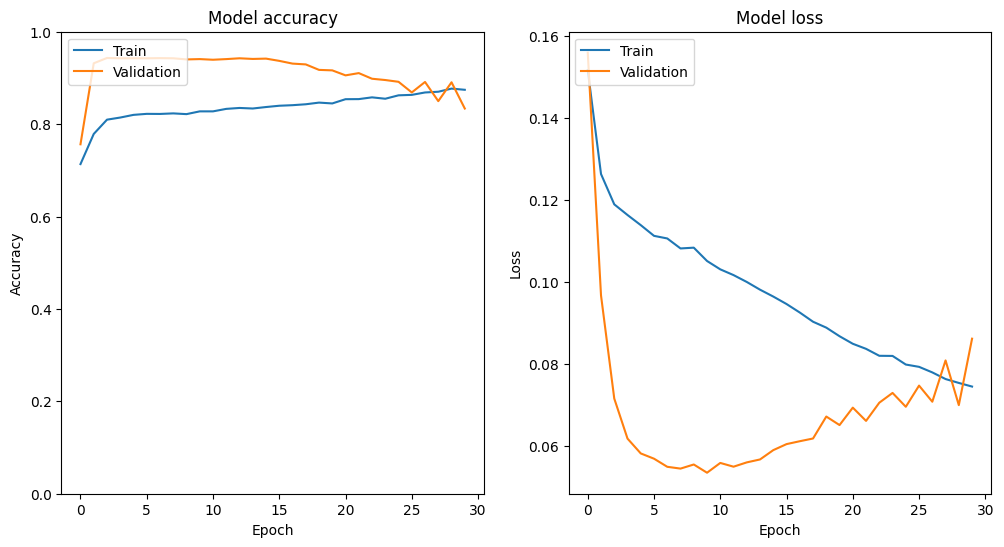

0.6370586034062861

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]

#model_PLSTM = build_paper_lstm(input_shape, num_classes)
#model_CNNLSTM =  build_cnn_lstm(input_shape, num_classes)
#model_BANET = build_banet_model()

model_best = build_banet_model_late_test()
y_pred, y_true, H, model = model_pipeline(model_best)
plot_history(H)
f1_score(y_true, y_pred, average='macro')

In [ ]:
num_run = 20
best_F1 = 0
for i in range(0, num_run):
    model_best = build_banet_model_late_test()
    y_pred, y_true, H, model = model_pipeline(model_best)
    # plot_history(H)
    f1_temp = f1_score(y_true, y_pred, average='macro')
    if f1_temp > best_F1:
        best_F1 = f1_temp
        model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/comp0053_dataset/' + 'model' + '.hdf5')

print(best_F1)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 25s 397ms/step - loss: 0.1457 - binary_accuracy: 0.7207 - val_loss: 0.1401 - val_binary_accuracy: 0.9083 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 120ms/step - loss: 0.1252 - binary_accuracy: 0.7899 - val_loss: 0.0980 - val_binary_accuracy: 0.9435 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1186 - binary_accuracy: 0.8109 - val_loss: 0.0808 - val_binary_accuracy: 0.9432 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1161 - binary_accuracy: 0.8142 - val_loss: 0.0743 - val_binary_accuracy: 0.9428 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 26s 401ms/step - loss: 0.1465 - binary_accuracy: 0.7384 - val_loss: 0.1517 - val_binary_accuracy: 0.8606 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 120ms/step - loss: 0.1278 - binary_accuracy: 0.7903 - val_loss: 0.1022 - val_binary_accuracy: 0.9414 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1194 - binary_accuracy: 0.8113 - val_loss: 0.0868 - val_binary_accuracy: 0.9414 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1158 - binary_accuracy: 0.8176 - val_loss: 0.0793 - val_binary_accuracy: 0.9432 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 26s 420ms/step - loss: 0.1556 - binary_accuracy: 0.7229 - val_loss: 0.1520 - val_binary_accuracy: 0.7954 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1329 - binary_accuracy: 0.7690 - val_loss: 0.0916 - val_binary_accuracy: 0.9289 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1210 - binary_accuracy: 0.8073 - val_loss: 0.0702 - val_binary_accuracy: 0.9449 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 119ms/step - loss: 0.1162 - binary_accuracy: 0.8158 - val_loss: 0.0636 - val_binary_accuracy: 0.9446 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 26s 411ms/step - loss: 0.1508 - binary_accuracy: 0.7322 - val_loss: 0.1553 - val_binary_accuracy: 0.8034 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 120ms/step - loss: 0.1309 - binary_accuracy: 0.7811 - val_loss: 0.1039 - val_binary_accuracy: 0.9310 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 119ms/step - loss: 0.1242 - binary_accuracy: 0.7921 - val_loss: 0.0779 - val_binary_accuracy: 0.9428 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 120ms/step - loss: 0.1161 - binary_accuracy: 0.8208 - val_loss: 0.0717 - val_binary_accuracy: 0.9432 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 26s 396ms/step - loss: 0.1437 - binary_accuracy: 0.7191 - val_loss: 0.1423 - val_binary_accuracy: 0.8261 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1280 - binary_accuracy: 0.7729 - val_loss: 0.0877 - val_binary_accuracy: 0.9348 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 119ms/step - loss: 0.1209 - binary_accuracy: 0.8019 - val_loss: 0.0686 - val_binary_accuracy: 0.9411 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1180 - binary_accuracy: 0.8101 - val_loss: 0.0595 - val_binary_accuracy: 0.9421 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 26s 524ms/step - loss: 0.1442 - binary_accuracy: 0.7484 - val_loss: 0.1518 - val_binary_accuracy: 0.8313 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1248 - binary_accuracy: 0.7959 - val_loss: 0.0976 - val_binary_accuracy: 0.9397 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1184 - binary_accuracy: 0.8121 - val_loss: 0.0787 - val_binary_accuracy: 0.9432 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 119ms/step - loss: 0.1148 - binary_accuracy: 0.8188 - val_loss: 0.0725 - val_binary_accuracy: 0.9446 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 25s 397ms/step - loss: 0.1539 - binary_accuracy: 0.6939 - val_loss: 0.1573 - val_binary_accuracy: 0.7829 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1285 - binary_accuracy: 0.7817 - val_loss: 0.0954 - val_binary_accuracy: 0.9404 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1205 - binary_accuracy: 0.8069 - val_loss: 0.0717 - val_binary_accuracy: 0.9421 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1165 - binary_accuracy: 0.8130 - val_loss: 0.0639 - val_binary_accuracy: 0.9425 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 27s 399ms/step - loss: 0.1492 - binary_accuracy: 0.7386 - val_loss: 0.1539 - val_binary_accuracy: 0.8013 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1281 - binary_accuracy: 0.7847 - val_loss: 0.0969 - val_binary_accuracy: 0.9418 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1206 - binary_accuracy: 0.8019 - val_loss: 0.0797 - val_binary_accuracy: 0.9414 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1167 - binary_accuracy: 0.8144 - val_loss: 0.0714 - val_binary_accuracy: 0.9428 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 25s 400ms/step - loss: 0.1423 - binary_accuracy: 0.7666 - val_loss: 0.1472 - val_binary_accuracy: 0.8836 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1256 - binary_accuracy: 0.7839 - val_loss: 0.0952 - val_binary_accuracy: 0.9439 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1177 - binary_accuracy: 0.8125 - val_loss: 0.0753 - val_binary_accuracy: 0.9453 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1156 - binary_accuracy: 0.8172 - val_loss: 0.0663 - val_binary_accuracy: 0.9435 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 28s 412ms/step - loss: 0.1402 - binary_accuracy: 0.7674 - val_loss: 0.1450 - val_binary_accuracy: 0.8547 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1237 - binary_accuracy: 0.7953 - val_loss: 0.0918 - val_binary_accuracy: 0.9421 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1184 - binary_accuracy: 0.8128 - val_loss: 0.0749 - val_binary_accuracy: 0.9411 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1158 - binary_accuracy: 0.8160 - val_loss: 0.0662 - val_binary_accuracy: 0.9418 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 25s 397ms/step - loss: 0.1446 - binary_accuracy: 0.7322 - val_loss: 0.1506 - val_binary_accuracy: 0.8418 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1222 - binary_accuracy: 0.8013 - val_loss: 0.1025 - val_binary_accuracy: 0.9397 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1178 - binary_accuracy: 0.8113 - val_loss: 0.0808 - val_binary_accuracy: 0.9439 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1153 - binary_accuracy: 0.8180 - val_loss: 0.0715 - val_binary_accuracy: 0.9442 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 25s 392ms/step - loss: 0.1521 - binary_accuracy: 0.7452 - val_loss: 0.1468 - val_binary_accuracy: 0.8271 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1286 - binary_accuracy: 0.7861 - val_loss: 0.0896 - val_binary_accuracy: 0.9414 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1226 - binary_accuracy: 0.8027 - val_loss: 0.0727 - val_binary_accuracy: 0.9421 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1171 - binary_accuracy: 0.8166 - val_loss: 0.0691 - val_binary_accuracy: 0.9418 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 28s 393ms/step - loss: 0.1531 - binary_accuracy: 0.7113 - val_loss: 0.1603 - val_binary_accuracy: 0.7400 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1309 - binary_accuracy: 0.7753 - val_loss: 0.1030 - val_binary_accuracy: 0.9230 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 119ms/step - loss: 0.1211 - binary_accuracy: 0.7983 - val_loss: 0.0798 - val_binary_accuracy: 0.9394 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1171 - binary_accuracy: 0.8123 - val_loss: 0.0700 - val_binary_accuracy: 0.9407 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 25s 395ms/step - loss: 0.1520 - binary_accuracy: 0.7091 - val_loss: 0.1578 - val_binary_accuracy: 0.7483 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1286 - binary_accuracy: 0.7897 - val_loss: 0.0964 - val_binary_accuracy: 0.9296 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 119ms/step - loss: 0.1215 - binary_accuracy: 0.8051 - val_loss: 0.0726 - val_binary_accuracy: 0.9435 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1179 - binary_accuracy: 0.8130 - val_loss: 0.0647 - val_binary_accuracy: 0.9421 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 25s 396ms/step - loss: 0.1486 - binary_accuracy: 0.7328 - val_loss: 0.1496 - val_binary_accuracy: 0.8181 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1298 - binary_accuracy: 0.7857 - val_loss: 0.0911 - val_binary_accuracy: 0.9404 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1231 - binary_accuracy: 0.8037 - val_loss: 0.0754 - val_binary_accuracy: 0.9404 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1186 - binary_accuracy: 0.8142 - val_loss: 0.0683 - val_binary_accuracy: 0.9418 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 28s 395ms/step - loss: 0.1522 - binary_accuracy: 0.7139 - val_loss: 0.1470 - val_binary_accuracy: 0.8578 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1290 - binary_accuracy: 0.7889 - val_loss: 0.0991 - val_binary_accuracy: 0.9369 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 120ms/step - loss: 0.1204 - binary_accuracy: 0.8069 - val_loss: 0.0806 - val_binary_accuracy: 0.9442 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1157 - binary_accuracy: 0.8198 - val_loss: 0.0755 - val_binary_accuracy: 0.9432 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 25s 401ms/step - loss: 0.1534 - binary_accuracy: 0.6852 - val_loss: 0.1543 - val_binary_accuracy: 0.7919 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1290 - binary_accuracy: 0.7795 - val_loss: 0.1069 - val_binary_accuracy: 0.9338 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1219 - binary_accuracy: 0.8017 - val_loss: 0.0814 - val_binary_accuracy: 0.9428 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1165 - binary_accuracy: 0.8121 - val_loss: 0.0724 - val_binary_accuracy: 0.9418 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 25s 405ms/step - loss: 0.1474 - binary_accuracy: 0.6933 - val_loss: 0.1470 - val_binary_accuracy: 0.9209 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1262 - binary_accuracy: 0.7881 - val_loss: 0.0983 - val_binary_accuracy: 0.9411 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1189 - binary_accuracy: 0.8142 - val_loss: 0.0797 - val_binary_accuracy: 0.9418 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1159 - binary_accuracy: 0.8180 - val_loss: 0.0719 - val_binary_accuracy: 0.9421 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 28s 398ms/step - loss: 0.1464 - binary_accuracy: 0.7281 - val_loss: 0.1652 - val_binary_accuracy: 0.7219 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1252 - binary_accuracy: 0.7979 - val_loss: 0.0942 - val_binary_accuracy: 0.9362 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1184 - binary_accuracy: 0.8087 - val_loss: 0.0724 - val_binary_accuracy: 0.9404 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 116ms/step - loss: 0.1152 - binary_accuracy: 0.8125 - val_loss: 0.0643 - val_binary_accuracy: 0.9421 - lr: 0.0010

Ep


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
11/11 [==============================] - 25s 397ms/step - loss: 0.1508 - binary_accuracy: 0.7113 - val_loss: 0.1620 - val_binary_accuracy: 0.7578 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1263 - binary_accuracy: 0.7905 - val_loss: 0.0990 - val_binary_accuracy: 0.9303 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
11/11 [==============================] - 1s 118ms/step - loss: 0.1177 - binary_accuracy: 0.8188 - val_loss: 0.0808 - val_binary_accuracy: 0.9428 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
11/11 [==============================] - 1s 117ms/step - loss: 0.1150 - binary_accuracy: 0.8194 - val_loss: 0.0721 - val_binary_accuracy: 0.9432 - lr: 0.0010

Ep

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_true, y_pred, average='macro')

0.6844800300421126

In [ ]:
Xtt = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
Ytt = np.argmax(y_train, axis=1)

Xvv = X_valid.reshape((X_valid.shape[0],X_valid.shape[1]*X_valid.shape[2]))
Yvv = np.argmax(y_valid, axis=1)

In [ ]:
from sklearn.svm import SVC

xx = SVC()
xx.fit(Xtt,Ytt)
xx.score(Xvv,Yvv)

0.9334262809341234

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rr = RandomForestClassifier()
rr.fit(Xtt,Ytt)

RandomForestClassifier()

In [ ]:
pred = rr.predict(Xvv)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Yvv,pred))
print(confusion_matrix(Yvv,pred))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      2698
           1       0.10      0.35      0.16       171

    accuracy                           0.78      2869
   macro avg       0.53      0.58      0.51      2869
weighted avg       0.90      0.78      0.83      2869

[[2165  533]
 [ 111   60]]


In [ ]:
np.unique(Yvv,return_counts=True)

(array([0, 1]), array([2698,  171]))

In [ ]:
3293/(3293+223)

0.9365756541524459